In [2]:
# import packages
import sys
import os.path
import numpy as np
np.seterr(divide='ignore',invalid='ignore')
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import seaborn as sns
sns.set()

from spykshrk.realtime.datatypes import Datatypes
import loren_frank_data_processing as lfdp
from loren_frank_data_processing import Animal
import trodes2SS
import scipy as sp
import sungod_util
from spykshrk.franklab.data_containers import RippleTimes, pos_col_format#FlatLinearPosition, SpikeFeatures, Posteriors, \
         #EncodeSettings, pos_col_format, SpikeObservation, RippleTimes, DayEpochEvent, DayEpochTimeSeries

%load_ext autoreload
%autoreload 2

idx = pd.IndexSlice
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 120)

In [ ]:
# cell to start up holoviews
import holoviews as hv

import scipy as sp

hv.extension('bokeh')

In [ ]:
# cell to test and make sure holoviews and bokeh are working
coords = np.random.rand(50,2)
points = hv.Points(coords)

points.opts(color='k', marker='+', size=10)

In [11]:
# cell to read real-time hdf5 file

#12-17, bill run session 3
#hdf_file = '/stelmo/mcoulter/spykshrk_output/bill/20191217_bill_05_r3_westerlies_streaming.rec_merged.h5'

#12-22, bill run session 
#hdf_file = '/stelmo/mcoulter/bill/raw/20191222/spykshrk_realtime_rec_files/20191222_bill_02_r1_westerlies_streaming.rec_merged.h5'

#1-17, remy day 20, epoch 2, 15 tets, ~1 hour
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_posterior_sum_1_16_1.rec_merged.h5'

#1-20, remy, day 20 , epoch 2, 15 tets, 100 uV
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_decoder_15tet_1_20_100uV_decode.rec_merged.h5'

#1-20, remy, day 20 , epoch 2, 19 tets, 150 uV
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_1_22_no_timer.rec_merged.h5'

# whole session remy, posterior sum from 9-14, 150 uV?
#hdf_file = '/stelmo/mcoulter/spykshrk_realtime_vortex/runs_on_drought/test_single_MEC.rec_merged_posterior_sum.h5'

# remy, 2 minutes trodesconf with 100 uV spike threshold
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_spike_thresh_1_24_60uV.rec_merged.h5'

# remy, 2 minutes trodeconf with 60 uV spike threshold
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_spike_thresh_1_24_100uV.rec_merged.h5'

# remy, 2 minutes trodeconf with 60 uV spike threshold
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_spike_thresh_1_24_100_100.rec_merged.h5'

# old spyskhrk code from 9-2019
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_spike_thresh_1_24_150_sept_2019.rec_merged.h5'

# old trodes config file - no LFP ref
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_spike_thresh_1_24_100_150_new_config.rec_merged.h5'

# same 2 minutes run on westerlies
#hdf_file = '/stelmo/mcoulter/spykshrk_output/bill/20200124_remy_5tet_westerlies.rec_merged.h5'

# 2 tets LFP and decode greenflash
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_spike_thresh_1_24_100_2_tets.rec_merged.h5'

# ripple test 12-04 greenflash (tets 28 and 30)
#hdf_file = '/stelmo/mcoulter/spykshrk_realtime_vortex/output/20191204_4_greenflash_ripple.rec_merged.h5'

# tetrode 4 only greenflash 7-20-19
#hdf_file = '/stelmo/mcoulter/spykshrk_realtime_vortex/output/test_single_MEC.rec_merged_4_only.h5'

# origin_header 10-25-19 on greenflash
#hdf_file = '/stelmo/mcoulter/spykshrk_realtime_vortex/output/test_single_MEC_origin_header.rec_merged.h5'

# ripple 02 greenflash 11-02-19
#hdf_file = '/stelmo/mcoulter/spykshrk_realtime_vortex/output/20191102_greenflash_ripple_02.rec_merged.h5'

# 12-02 greenflash (tets 28 and 30)
#hdf_file = '/stelmo/mcoulter/spykshrk_realtime_vortex/output/20191202_2_greenflash_ripple.rec_merged.h5'

# 10-18 15 min playback on drought
#hdf_file = '/stelmo/mcoulter/spykshrk_realtime_vortex/runs_on_drought/test_single_MEC.rec_merged_15min_playback_1018.h5'

# 1-26 2 min playback new on drought
#hdf_file = '/stelmo/mcoulter/spykshrk_output/drought/test_single_MEC_drought_12_1_26.rec_merged.h5'

# bill 12-18-19 r1 - westerlies
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/20191218_bill_02_r1_westerlies_streaming.rec_merged.h5'

# 1-27 2 min greenflash old trodes
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_spike_thresh_1_27_old_trodes.rec_merged.h5'

# 1-27 old trodes 19 tets on westerlies, 30 min
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_1_27_old_trodes.rec_merged.h5'

# 1-31 remy, westerlies, new posterior sum
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_1_31_new_post_sum.rec_merged.h5'

# 2-2 remy westerlies, decoder with 1 bin delay
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_2_2_decoder_next_bin.rec_merged.h5'

# 2-2 remy westerlies, decoder with 1 bin delay
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_2_2_new_post_sum.rec_merged.h5'

# 2-3 remy test greenflash - changing ripple numbering
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_1_30_test_running_sum_1.rec_merged.h5'

# 2-3 1 bin delay original, 2 mins
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_2_3_next_bin_no_spike_1.rec_merged.h5'

# 2-3 1 bin delay new no spike, 2 mins
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_2_3_next_bin_no_spike_2.rec_merged.h5'

# 2-3 NO 1 bin delay, 2 mins
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_2_3_next_bin_no_spike_3.rec_merged.h5'

# 2-3 NO 1 bin delay, changed no spike, 2 mins
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_2_3_next_bin_no_spike_4.rec_merged.h5'

# 2-3 with 1 bin delay, changed no spike, 2 mins
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_2_3_next_bin_no_spike_5.rec_merged.h5'

# 2-3 with 1 bin delay, fixed hole in no spike loop
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_2_3_next_bin_no_spike_6.rec_merged.h5'

# 2-4 with 1 bin delay, commented out self.current_time_bin = spike_time_bin
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_2_4_next_bin_no_spike_1.rec_merged.h5'

# 2-4 with 1 bin delay, commented out self.current_time_bin = spike_time_bin
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_2_4_next_bin_no_spike_3.rec_merged.h5'

# 2-3 with no delay, no_spike loop fix
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_2_3_no_spike_fix.rec_merged.h5'

# 2-4 1 bin delay, no_spike loop fix sorta
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_2_4_delay_no_spike.rec_merged.h5'

# 2-5 1 bin delay, no_spike loop fix, 50 msec posterior lockout
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_2_5_post_lockout.rec_merged.h5'

# 2-6 velocity fix
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_2_6_15tet_velocity.rec_merged.h5'

# 2-6 1 bin delay, no_spike loop fix sorta
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_2_6_encode_all_time.rec_merged.h5'

# 2-19 new compile of trodes 20
hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_2_19_missing_spikes.rec_merged.h5'

# 2-19 trodes 20 from october 9
hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_2_19_missing_spikes_oct_09.rec_merged.h5'


store = pd.HDFStore(hdf_file, mode='r')

In [64]:
# 1 hour with NO decoder delay
encoder_data = store['rec_3']
decoder_data = store['rec_4']
decoder_missed_spikes = store['rec_5']
likelihood_data = store['rec_6']
ripple_data = store['rec_1']
#stim_state = store['rec_10']
stim_lockout = store['rec_11']
stim_message = store['rec_12']
timing = store['rec_100']

In [79]:
# decoder with 1 bin delay - not working
encoder_data1 = store['rec_3']
decoder_data1 = store['rec_4']
decoder_missed_spikes1 = store['rec_5']
likelihood_data1 = store['rec_6']
ripple_data1 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout1 = store['rec_11']
stim_message1 = store['rec_12']
#timing1 = store['rec_100']

In [108]:
# not sure what this one is
encoder_data2 = store['rec_3']
decoder_data2 = store['rec_4']
decoder_missed_spikes2 = store['rec_5']
likelihood_data2 = store['rec_6']
ripple_data2 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout2 = store['rec_11']
stim_message2 = store['rec_12']
timing2 = store['rec_100']

In [170]:
# check new ripple numbering
encoder_data3 = store['rec_3']
decoder_data3 = store['rec_4']
decoder_missed_spikes3 = store['rec_5']
likelihood_data3 = store['rec_6']
ripple_data3 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout3 = store['rec_11']
stim_message3 = store['rec_12']
timing3 = store['rec_100']

In [248]:
# next bin no spike old
encoder_data4 = store['rec_3']
decoder_data4 = store['rec_4']
decoder_missed_spikes4 = store['rec_5']
likelihood_data4 = store['rec_6']
ripple_data4 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout4 = store['rec_11']
stim_message4 = store['rec_12']
timing4 = store['rec_100']

In [250]:
# next bin no spike new
encoder_data5 = store['rec_3']
decoder_data5 = store['rec_4']
decoder_missed_spikes5 = store['rec_5']
likelihood_data5 = store['rec_6']
ripple_data5 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout5 = store['rec_11']
stim_message5 = store['rec_12']
timing5 = store['rec_100']

In [259]:
# NO next bin delay
encoder_data6 = store['rec_3']
decoder_data6 = store['rec_4']
decoder_missed_spikes6 = store['rec_5']
likelihood_data6 = store['rec_6']
ripple_data6 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout6 = store['rec_11']
stim_message6 = store['rec_12']
timing6 = store['rec_100']

In [290]:
# changed no spike
encoder_data7 = store['rec_3']
decoder_data7 = store['rec_4']
decoder_missed_spikes7 = store['rec_5']
likelihood_data7 = store['rec_6']
ripple_data7 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout7 = store['rec_11']
stim_message7 = store['rec_12']
timing7 = store['rec_100']

In [296]:
# changed no spike and 1 bin delay
encoder_data8 = store['rec_3']
decoder_data8 = store['rec_4']
decoder_missed_spikes8 = store['rec_5']
likelihood_data8 = store['rec_6']
ripple_data8 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout8 = store['rec_11']
stim_message8 = store['rec_12']
timing8 = store['rec_100']

In [306]:
# 1 bin delay fix no spike loop
encoder_data9 = store['rec_3']
decoder_data9 = store['rec_4']
decoder_missed_spikes9 = store['rec_5']
likelihood_data9 = store['rec_6']
ripple_data9 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout9 = store['rec_11']
stim_message9 = store['rec_12']
timing9 = store['rec_100']

In [320]:
# 1 bin delay comment out time bin update
encoder_data10 = store['rec_3']
decoder_data10 = store['rec_4']
decoder_missed_spikes10 = store['rec_5']
likelihood_data10 = store['rec_6']
ripple_data10 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout10 = store['rec_11']
stim_message10 = store['rec_12']
timing10 = store['rec_100']

In [330]:
# 1 bin delay comment out time bin update, and -1 to no_spike
encoder_data11 = store['rec_3']
decoder_data11 = store['rec_4']
decoder_missed_spikes11 = store['rec_5']
likelihood_data11 = store['rec_6']
ripple_data11 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout11 = store['rec_11']
stim_message11 = store['rec_12']
timing11 = store['rec_100']

In [335]:
# no delay, no spike fix
encoder_data12 = store['rec_3']
decoder_data12 = store['rec_4']
decoder_missed_spikes12 = store['rec_5']
likelihood_data12 = store['rec_6']
ripple_data12 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout12 = store['rec_11']
stim_message12 = store['rec_12']
timing12 = store['rec_100']

In [345]:
# with delay, no spike fix sorta
encoder_data13 = store['rec_3']
decoder_data13 = store['rec_4']
decoder_missed_spikes13 = store['rec_5']
likelihood_data13 = store['rec_6']
ripple_data13 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout13 = store['rec_11']
stim_message13 = store['rec_12']
timing13 = store['rec_100']

In [491]:
# with delay, no spike fix, 50msec post sum lockout
encoder_data14 = store['rec_3']
decoder_data14 = store['rec_4']
decoder_missed_spikes14 = store['rec_5']
likelihood_data14 = store['rec_6']
ripple_data14 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout14 = store['rec_11']
stim_message14 = store['rec_12']
timing14 = store['rec_100']

In [604]:
# with delay, velocity fix
encoder_data15 = store['rec_3']
decoder_data15 = store['rec_4']
decoder_missed_spikes15 = store['rec_5']
likelihood_data15 = store['rec_6']
ripple_data15 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout15 = store['rec_11']
stim_message15 = store['rec_12']
timing15 = store['rec_100']

In [624]:
# with delay, velocity fix
encoder_data16 = store['rec_3']
decoder_data16 = store['rec_4']
decoder_missed_spikes16 = store['rec_5']
likelihood_data16 = store['rec_6']
ripple_data16 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout16 = store['rec_11']
#stim_message16 = store['rec_12']
timing16 = store['rec_100']
occupancy16 = store['rec_7']

In [630]:
# with delay, encode all time
encoder_data17 = store['rec_3']
decoder_data17 = store['rec_4']
decoder_missed_spikes17 = store['rec_5']
likelihood_data17 = store['rec_6']
ripple_data17 = store['rec_1']
#stim_state = store['rec_10']
#stim_lockout17 = store['rec_11']
#stim_message17 = store['rec_12']
timing17 = store['rec_100']
occupancy17 = store['rec_7']

In [4]:
# check for missing spikes trodes 20
encoder_data18 = store['rec_3']
timing18 = store['rec_100']


In [12]:
# check for missing spikes trodes 20 - oct 9
encoder_data19 = store['rec_3']
timing19 = store['rec_100']

In [635]:
# generate posterior error dataframe for real-time data
# remy 20 2, encoding on all spikes

post_error = decoder_data17.copy()

#post_error.drop(columns=['rec_ind', 'timestamp','real_pos_time','real_pos','spike_count'],inplace=True)
post_error.drop(columns=['rec_ind','bin_timestamp','wall_time','velocity','real_pos',
                         'raw_x','raw_y','smooth_x','smooth_y','next_bin',
                         'spike_count','ripple','ripple_number','ripple_length',
                         'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                         'arm6','arm7','arm8'], inplace=True)

post_error.fillna(0,inplace=True)
post_error['max_position'] = post_error.idxmax(axis=1)
post_error['max_position'] = post_error['max_position'].str.replace('x','')
post_error['max_position'] = post_error['max_position'].astype(int)

#now need to add back columns 'timestamp','real_pos_time','real_pos'
# try adding back spike_count too
post_error['timestamp'] = decoder_data17['bin_timestamp']
post_error['real_vel'] = decoder_data17['velocity']
post_error['real_pos'] = decoder_data17['real_pos']
post_error['spike_count'] = decoder_data17['spike_count']
#this is the error column in centimeters
post_error['error_cm'] = abs(post_error['max_position']-decoder_data17['real_pos'])*5

post_error
post_error_plot = post_error.copy()
#post_error_plot = post_error_plot[500:580000]
post_error_plot = post_error_plot[post_error_plot['real_vel']>8]
post_error_plot.shape

(200458, 143)

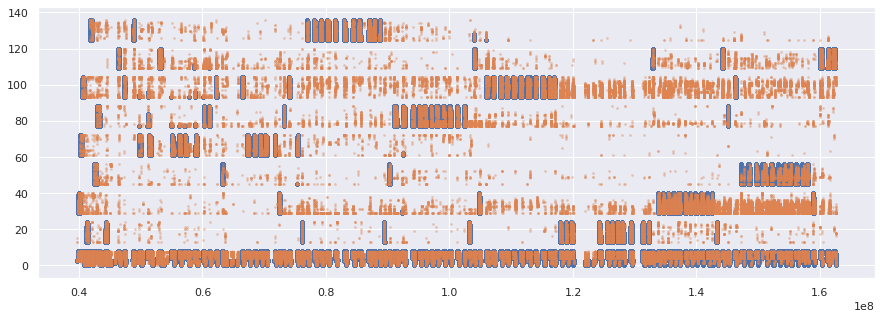

In [636]:
# remy 20 2, encoding on all spikes
plt.figure(figsize=(15,5))

plt.scatter(post_error_plot['timestamp'].values,post_error_plot['real_pos'].values,s=10)
plt.scatter(post_error_plot['timestamp'].values,post_error_plot['max_position'].values,s=3,alpha=0.3)


In [637]:
#calculate max for offline posteriors
post_to_merge = posteriors2.copy()

#calculate posterior max
post_to_merge1 = post_to_merge.drop(['num_spikes','dec_bin','ripple_grp'], axis=1)
post_to_merge1.fillna(0,inplace=True)
post_to_merge1['posterior_max'] = post_to_merge1.idxmax(axis=1)
post_to_merge1['posterior_max'] = post_to_merge1['posterior_max'].str.replace('x','')
post_to_merge1['posterior_max'] = post_to_merge1['posterior_max'].astype(int)

#post_to_merge.reset_index(level=['timestamp'],inplace=True)
post_to_merge1.reset_index(inplace=True)
post_to_merge1['timestamp1']=post_to_merge1['timestamp']

#calculate posterior max

#post_to_merge.set_index('timestamp', append=True, inplace=True)
#post_to_merge.set_index('dat','epoch','timestamp', 'time',append=True, inplace=True)
#post_to_merge1 = post_to_merge.reorder_levels(['day', 'epoch', 'timestamp', 'time'])
post_to_merge1

pos_vel = binned_linear_pos.copy()
pos_vel1 = pos_vel.reset_index()
pos_vel1['timestamp1'] = pos_vel1['timestamp']
pos_vel2 = pos_vel1.drop(['day','epoch','time','timestamp'], axis=1)

posterior_with_pos_vel = pd.merge_asof(post_to_merge1,pos_vel2,on='timestamp1',direction='nearest')
posterior_with_pos_vel['error_cm'] = abs(posterior_with_pos_vel['posterior_max']-posterior_with_pos_vel['linpos_flat'])*5
posterior_with_pos_vel

post_error_plot_off = posterior_with_pos_vel.copy()
#post_error_plot_off = post_error_plot[100:821700]
post_error_plot_off = post_error_plot_off[post_error_plot_off['linvel_flat']>8]
post_error_plot_off.shape

(168767, 155)

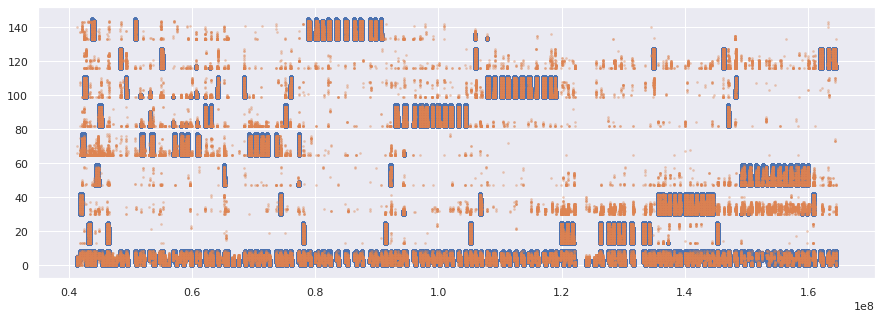

In [638]:
#offline posterior - remy 20, 2, 150 uV threshold
plt.figure(figsize=(15,5))

plt.scatter(post_error_plot_off['timestamp'].values,post_error_plot_off['linpos_flat'].values,s=10)
plt.scatter(post_error_plot_off['timestamp'].values,post_error_plot_off['posterior_max'].values,s=3,alpha=0.3)

In [495]:
pd.set_option('display.max_rows', 10)
encoder_data14.shape
decoder_missed_spikes14.shape
#decoder_data14


(24628, 5)

In [331]:
print(decoder_data4.shape)
print(decoder_data5.shape)
print(decoder_data6.shape)
print(decoder_data7.shape)
print(decoder_data8.shape)
print(decoder_data9.shape)
print(decoder_data10.shape)
print(decoder_data11.shape)

print(decoder_missed_spikes4.shape)
print(decoder_missed_spikes5.shape)
print(decoder_missed_spikes6.shape)
print(decoder_missed_spikes7.shape)
print(decoder_missed_spikes8.shape)
print(decoder_missed_spikes9.shape)
print(decoder_missed_spikes10.shape)
print(decoder_missed_spikes11.shape)

print(decoder_data4['spike_count'].sum())
print(decoder_data5['spike_count'].sum())
print(decoder_data6['spike_count'].sum())
print(decoder_data7['spike_count'].sum())
print(decoder_data8['spike_count'].sum())
print(decoder_data9['spike_count'].sum())
print(decoder_data10['spike_count'].sum())
print(decoder_data11['spike_count'].sum())



(15193, 161)
(17497, 161)
(19209, 161)
(23981, 161)
(22425, 161)
(22803, 161)
(23981, 161)
(23925, 161)
(27, 5)
(32, 5)
(38, 5)
(37, 5)
(34, 5)
(47, 5)
(42, 5)
(21, 5)
7098
7057
7073
7063
7052
7063
7064
7065


In [324]:
print(encoder_data7.shape)
print(encoder_data10.shape)

(7054, 141)
(7051, 141)


(array([ 0., 17.,  3.,  2.,  2.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  1.,
         0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,
         0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 <a list of 39 Patch objects>)

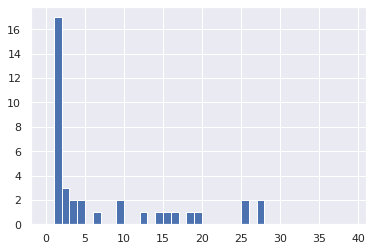

In [333]:
plt.hist(decoder_missed_spikes7['late_bin'].values-decoder_missed_spikes7['real_bin'].values,bins=np.arange(0,40))

In [327]:
encoder_data7

,rec_ind,timestamp,elec_grp_id,position,x000,x001,x002,x003,x004,x005,...,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136
0,1,40273652,4,72.0,0.007326,0.007326,0.007326,0.007326,7.326007e-03,0.007326,...,7.326007e-03,0.007326,7.326007e-03,0.007326,7.326007e-03,0.007326,7.326007e-03,0.007326,7.326007e-03,0.007326
1,1,40273831,11,72.0,0.007326,0.007326,0.007326,0.007326,7.326007e-03,0.007326,...,7.326007e-03,0.007326,7.326007e-03,0.007326,7.326007e-03,0.007326,7.326007e-03,0.007326,7.326007e-03,0.007326
2,5,40274184,11,72.0,0.000021,0.000021,0.000021,0.000021,2.140065e-05,0.000021,...,2.140065e-05,0.000021,2.140065e-05,0.000021,2.140065e-05,0.000021,2.140065e-05,0.000021,2.140065e-05,0.000021
3,7,40274625,4,72.0,0.007326,0.007326,0.007326,0.007326,7.326007e-03,0.007326,...,7.326007e-03,0.007326,7.326007e-03,0.007326,7.326007e-03,0.007326,7.326007e-03,0.007326,7.326007e-03,0.007326
4,9,40274682,11,72.0,0.005835,0.005835,0.005835,0.005835,5.834972e-03,0.005835,...,5.834972e-03,0.005835,5.834972e-03,0.005835,5.834972e-03,0.005835,5.834972e-03,0.005835,5.834972e-03,0.005835
5,12,40275100,4,72.0,0.000026,0.000026,0.000026,0.000026,2.573080e-05,0.000026,...,2.573080e-05,0.000026,2.573080e-05,0.000026,2.573080e-05,0.000026,2.573080e-05,0.000026,2.573080e-05,0.000026
6,13,40275236,11,72.0,0.000040,0.000040,0.000040,0.000040,3.993740e-05,0.000040,...,3.993740e-05,0.000040,3.993740e-05,0.000040,3.993740e-05,0.000040,3.993740e-05,0.000040,3.993740e-05,0.000040
7,17,40275575,11,72.0,0.007326,0.007326,0.007326,0.007326,7.326007e-03,0.007326,...,7.326007e-03,0.007326,7.326007e-03,0.007326,7.326007e-03,0.007326,7.326007e-03,0.007326,7.326007e-03,0.007326
8,16,40275576,4,72.0,0.007326,0.007326,0.007326,0.007326,7.326007e-03,0.007326,...,7.326007e-03,0.007326,7.326007e-03,0.007326,7.326007e-03,0.007326,7.326007e-03,0.007326,7.326007e-03,0.007326
9,20,40275819,4,72.0,0.007218,0.007218,0.007218,0.007218,7.217548e-03,0.007218,...,7.217548e-03,0.007218,7.217548e-03,0.007218,7.217548e-03,0.007218,7.217548e-03,0.007218,7.217548e-03,0.007218


In [328]:
encoder_data10

,rec_ind,timestamp,elec_grp_id,position,x000,x001,x002,x003,x004,x005,...,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136
0,1,40269493,11,0.0,0.007299,0.007299,0.007299,0.007299,7.299270e-03,0.007299,...,7.299270e-03,0.007299,7.299270e-03,7.299270e-03,7.299270e-03,0.007299,7.299270e-03,0.007299,7.299270e-03,0.007299
1,4,40270593,11,0.0,0.007299,0.007299,0.007299,0.007299,7.299270e-03,0.007299,...,7.299270e-03,0.007299,7.299270e-03,7.299270e-03,7.299270e-03,0.007299,7.299270e-03,0.007299,7.299270e-03,0.007299
2,7,40270795,11,0.0,0.007299,0.007299,0.007299,0.007299,7.299270e-03,0.007299,...,7.299270e-03,0.007299,7.299270e-03,7.299270e-03,7.299270e-03,0.007299,7.299270e-03,0.007299,7.299270e-03,0.007299
3,1,40270795,4,0.0,0.007299,0.007299,0.007299,0.007299,7.299270e-03,0.007299,...,7.299270e-03,0.007299,7.299270e-03,7.299270e-03,7.299270e-03,0.007299,7.299270e-03,0.007299,7.299270e-03,0.007299
4,10,40270968,11,0.0,0.007299,0.007299,0.007299,0.007299,7.299270e-03,0.007299,...,7.299270e-03,0.007299,7.299270e-03,7.299270e-03,7.299270e-03,0.007299,7.299270e-03,0.007299,7.299270e-03,0.007299
5,13,40271177,11,0.0,0.007299,0.007299,0.007299,0.007299,7.299270e-03,0.007299,...,7.299270e-03,0.007299,7.299270e-03,7.299270e-03,7.299270e-03,0.007299,7.299270e-03,0.007299,7.299270e-03,0.007299
6,16,40271240,11,0.0,0.007299,0.007299,0.007299,0.007299,7.299270e-03,0.007299,...,7.299270e-03,0.007299,7.299270e-03,7.299270e-03,7.299270e-03,0.007299,7.299270e-03,0.007299,7.299270e-03,0.007299
7,4,40271652,4,0.0,0.007299,0.007299,0.007299,0.007299,7.299270e-03,0.007299,...,7.299270e-03,0.007299,7.299270e-03,7.299270e-03,7.299270e-03,0.007299,7.299270e-03,0.007299,7.299270e-03,0.007299
8,19,40271836,11,0.0,0.007299,0.007299,0.007299,0.007299,7.299270e-03,0.007299,...,7.299270e-03,0.007299,7.299270e-03,7.299270e-03,7.299270e-03,0.007299,7.299270e-03,0.007299,7.299270e-03,0.007299
9,7,40272273,4,72.0,0.007326,0.007326,0.007326,0.007326,7.326007e-03,0.007326,...,7.326007e-03,0.007326,7.326007e-03,7.326007e-03,7.326007e-03,0.007326,7.326007e-03,0.007326,7.326007e-03,0.007326


In [298]:
pd.set_option('display.max_rows', 50)
decoder_data[100950:101000]
decoder_data6[10950:11000]
decoder_data6[(decoder_data7['bin_timestamp'] > 42338850) & (decoder_data7['bin_timestamp'] < 42348450)]

,rec_ind,bin_timestamp,wall_time,velocity,real_pos,raw_x,raw_y,smooth_x,smooth_y,spike_count,...,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136
13769,28628,42867600,1.580771e+09,52.199234,46.0,524.0,295.0,512.5194,285.9621,2,...,1.351987e-05,1.016367e-04,1.132563e-04,2.622219e-05,6.670625e-05,1.007227e-04,3.364051e-09,1.421807e-04,1.056506e-04,6.032445e-05
13770,28630,42867750,1.580771e+09,54.078246,46.0,527.0,296.0,512.8908,286.3272,1,...,1.177442e-04,2.460518e-04,2.089675e-04,9.501514e-05,2.099261e-04,1.584215e-04,1.974070e-06,1.902181e-04,1.191186e-04,1.335092e-04
13771,28632,42867900,1.580771e+09,54.078246,46.0,527.0,296.0,512.8908,286.3272,0,...,2.284737e-04,2.878983e-04,2.804006e-04,2.684838e-04,2.518103e-04,2.211185e-04,2.146181e-04,2.016529e-04,2.450423e-04,2.263334e-04
13772,28634,42868050,1.580771e+09,54.078246,46.0,527.0,296.0,512.8908,286.3272,0,...,3.271010e-04,3.617921e-04,3.749901e-04,3.630857e-04,3.435305e-04,3.257613e-04,3.092168e-04,3.171081e-04,3.209725e-04,3.291105e-04
13773,28636,42868200,1.580771e+09,54.078246,46.0,527.0,296.0,512.8908,286.3272,0,...,7.592770e-04,4.499039e-04,4.617739e-04,4.557499e-04,4.395111e-04,4.217407e-04,4.130259e-04,4.114456e-04,4.180078e-04,4.219627e-04
13774,28638,42868350,1.580771e+09,54.078246,46.0,527.0,296.0,512.8908,286.3272,0,...,1.359795e-03,6.501584e-04,5.500337e-04,5.466055e-04,5.334000e-04,5.193059e-04,5.100494e-04,5.088172e-04,5.117649e-04,5.152289e-04
13775,28640,42868500,1.580771e+09,54.078246,46.0,527.0,296.0,512.8908,286.3272,0,...,1.997350e-03,9.434233e-04,6.751764e-04,6.366613e-04,6.265254e-04,6.144657e-04,6.063583e-04,6.038698e-04,6.055782e-04,6.076870e-04
13776,28642,42868800,1.580771e+09,57.460817,46.0,529.0,296.0,513.4389,286.7619,1,...,3.839357e-03,2.768297e-03,3.968683e-03,3.585954e-05,1.869374e-03,8.944631e-04,9.983187e-05,9.556995e-04,4.902739e-04,5.381903e-05
13777,28644,42868950,1.580771e+09,57.460817,46.0,529.0,296.0,513.4389,286.7619,0,...,6.059434e-03,3.587775e-03,2.333115e-03,2.036588e-03,1.022496e-03,1.043597e-03,7.422062e-04,6.088752e-04,5.936968e-04,2.961908e-04
13778,28646,42869100,1.580771e+09,57.460817,46.0,529.0,296.0,513.4389,286.7619,0,...,4.978938e-03,4.050908e-03,2.723891e-03,1.877684e-03,1.452311e-03,1.025333e-03,8.888943e-04,7.404843e-04,5.933572e-04,4.902071e-04


In [308]:
decoder_data9[(decoder_data9['bin_timestamp'] > 42338850) & (decoder_data9['bin_timestamp'] < 42348450)]

,rec_ind,bin_timestamp,wall_time,velocity,real_pos,raw_x,raw_y,smooth_x,smooth_y,spike_count,...,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136
13073,27035,42339000,1.580784e+09,106.882463,6.0,612.0,329.0,613.1646,360.1199,0,...,0.001938,0.003175,0.005000,8.271437e-03,0.011112,0.018959,3.299084e-02,0.057414,0.081995,0.098790
13074,27037,42339150,1.580784e+09,106.882463,6.0,612.0,329.0,613.1646,360.1199,0,...,0.002373,0.003435,0.005524,8.142321e-03,0.012747,0.020901,3.617481e-02,0.056968,0.078674,0.092321
13075,27039,42339300,1.580784e+09,106.882463,6.0,612.0,329.0,613.1646,360.1199,0,...,0.002709,0.003837,0.005740,8.811934e-03,0.013884,0.023131,3.771879e-02,0.056776,0.075297,0.086958
13076,27041,42339450,1.580784e+09,106.882463,6.0,612.0,329.0,613.1646,360.1199,0,...,0.003080,0.004152,0.006165,9.479276e-03,0.015216,0.024752,3.890043e-02,0.056108,0.072351,0.082306
13077,27043,42339600,1.580784e+09,106.882463,6.0,612.0,329.0,613.1646,360.1199,0,...,0.003431,0.004518,0.006629,1.027886e-02,0.016410,0.026115,3.960438e-02,0.055306,0.069624,0.078265
13078,27045,42339750,1.580784e+09,106.882463,6.0,612.0,329.0,613.1646,360.1199,0,...,0.003793,0.004908,0.007167,1.108956e-02,0.017517,0.027191,4.002171e-02,0.054374,0.067127,0.074700
13079,27047,42339900,1.580784e+09,106.882463,6.0,612.0,329.0,613.1646,360.1199,0,...,0.004164,0.005333,0.007740,1.189965e-02,0.018505,0.028049,4.020684e-02,0.053380,0.064820,0.071524
13080,27049,42340050,1.580784e+09,106.882463,6.0,612.0,329.0,613.1646,360.1199,0,...,0.004547,0.005785,0.008337,1.268178e-02,0.019381,0.028719,4.022316e-02,0.052353,0.062683,0.068667
13081,27051,42340200,1.580784e+09,106.882463,6.0,612.0,329.0,613.1646,360.1199,1,...,0.001961,0.004745,0.022085,6.139436e-07,0.081431,0.002268,3.991905e-02,0.010144,0.078353,0.044223
13082,27053,42340350,1.580784e+09,106.882463,6.0,612.0,329.0,613.1646,360.1199,0,...,0.002412,0.009596,0.008949,3.424579e-02,0.027709,0.040877,1.736160e-02,0.042460,0.043880,0.055121


In [288]:
for x in range(0):
    print(x)

In [263]:
decoder_data6

,rec_ind,bin_timestamp,wall_time,velocity,real_pos,raw_x,raw_y,smooth_x,smooth_y,spike_count,...,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136
0,1,40269450,1.580771e+09,277.638656,72.0,236.0,328.0,18.5260,25.7480,2,...,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569
1,3,40269600,1.580771e+09,277.638656,72.0,236.0,328.0,18.5260,25.7480,0,...,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569
2,5,40269750,1.580771e+09,277.638656,72.0,236.0,328.0,18.5260,25.7480,0,...,0.009568,0.009568,0.009568,0.009568,0.009568,0.009568,0.009568,0.009568,0.009568,0.009568
3,7,40269900,1.580771e+09,277.638656,72.0,236.0,328.0,18.5260,25.7480,0,...,0.009568,0.009568,0.009568,0.009568,0.009568,0.009568,0.009568,0.009568,0.009568,0.009568
4,9,40270050,1.580771e+09,277.638656,72.0,236.0,328.0,18.5260,25.7480,0,...,0.009568,0.009568,0.009568,0.009568,0.009568,0.009568,0.009568,0.009568,0.009568,0.009568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19204,39870,43871850,1.580771e+09,5.335411,0.0,777.0,435.0,776.7378,435.2113,0,...,0.000791,0.000708,0.000724,0.000733,0.001017,0.001273,0.001728,0.001904,0.001735,0.001394
19205,39872,43872000,1.580771e+09,5.335411,0.0,777.0,435.0,776.7378,435.2113,0,...,0.000868,0.000832,0.000813,0.000915,0.001096,0.001424,0.001717,0.001870,0.001759,0.001591
19206,39874,43872150,1.580771e+09,5.335411,0.0,777.0,435.0,776.7378,435.2113,0,...,0.001026,0.000928,0.000944,0.001031,0.001232,0.001497,0.001752,0.001862,0.001821,0.001729
19207,39876,43872300,1.580771e+09,5.335411,0.0,777.0,435.0,776.7378,435.2113,0,...,0.001191,0.001055,0.001056,0.001157,0.001339,0.001577,0.001785,0.001892,0.001884,0.001840


(array([12394.,     0.,     0.,     0.,     0.,  3760.,     0.,     0.,
            0.,  1342.]),
 array([150., 180., 210., 240., 270., 300., 330., 360., 390., 420., 450.]),
 <a list of 10 Patch objects>)

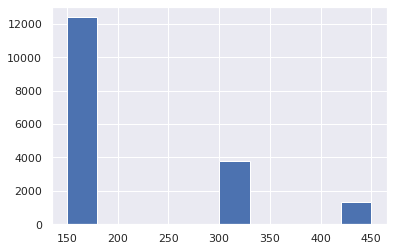

In [262]:
plt.hist(decoder_data5['bin_timestamp'].diff(),bins=10)

(1128856, 141)


(array([    0., 53069.,  9379.,  4705.,  2489.,  1222.,   479.,   145.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 8 Patch objects>)

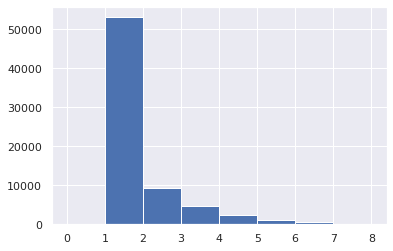

In [90]:
print(encoder_data.shape)
decoder_missed_spikes.shape
plt.hist(decoder_missed_spikes['late_bin'].values-decoder_missed_spikes['real_bin'].values,bins=np.arange(0,9))

In [89]:
np.sum(decoder_data1['spike_count'].values)

1281864

(1344905, 141)


(array([    0., 44339.,  9058.,  4910.,  2782.,  1352.,   458.,   128.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 8 Patch objects>)

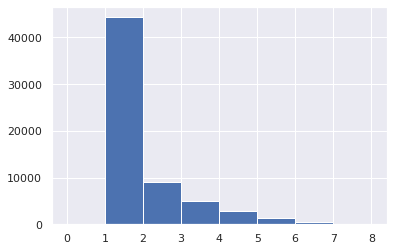

In [240]:
print(encoder_data1.shape)
decoder_missed_spikes1.shape
plt.hist(decoder_missed_spikes1['late_bin'].values-decoder_missed_spikes1['real_bin'].values,bins=np.arange(0,9))

(63059, 5)

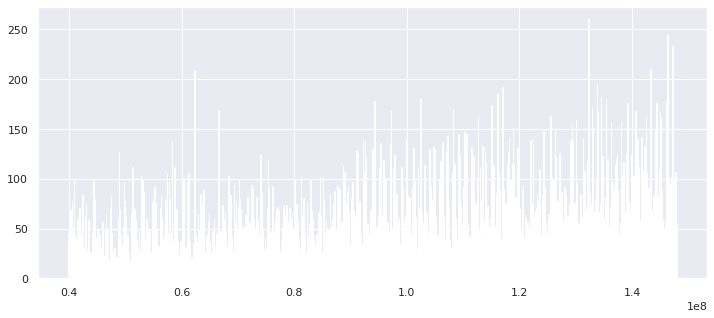

In [243]:
plt.figure(figsize=(12,5))
plt.hist(decoder_missed_spikes1['timestamp'].values,bins=1000)
decoder_missed_spikes1.shape

(71528, 5)

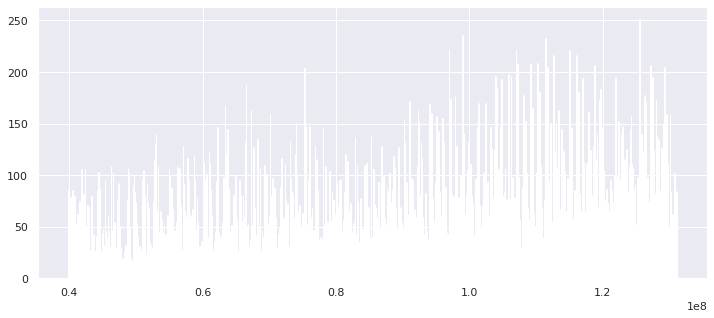

In [245]:
plt.figure(figsize=(12,5))
plt.hist(decoder_missed_spikes['timestamp'].values,bins=1000)
decoder_missed_spikes.shape

In [277]:
encoder_data19.shape
timing19[timing19['label']=='enc_recv'].shape
(ripple_data5[ripple_data5['elec_grp_id']==10].shape[0])/1

(1900445, 8)

In [ ]:
# loop to print number of marks per tetrode
spikes_in_from_trodes = timing15[timing15['label']=='enc_recv']
for i in np.arange(1,31):
    print(i, encoder_data17[encoder_data17['elec_grp_id']==i].shape)
#    remy: 4,6,9,10,11,12,13,14,15,17,19,20,21,22,23,24,25,26,28,29,30
# bill: 1,4,5,6,9,10,16,17,18,20,21,24,25,27,28,29,30

In [ ]:
# need to go back to timing notebook to see how i plotted the timing delay in the lfp nodes
timing1[timing1['label'] == 'rip_recv']

In [ ]:
# look at how many lines per ripple in stim_message
stim_message1['next_ripple']=stim_message1['ripple_number'].diff()
stim_message1

<IPython.core.display.Javascript object>


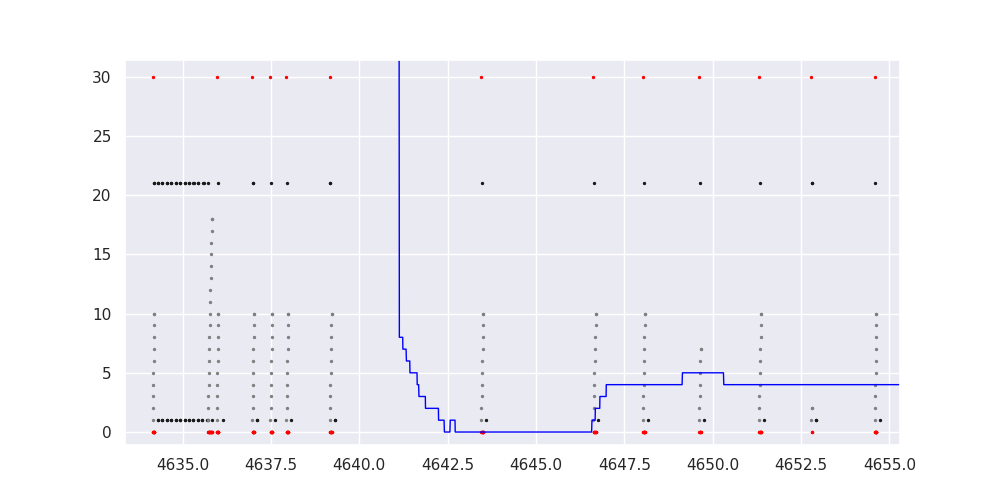

In [14]:
%matplotlib notebook

# plot to confirm that stim message is 500 msec after ripple (line up with lockout state)
# and to see how the merged changed the time stamps for stim message = 1
plt.figure(figsize=(10,5))
#realtime position with adjusted timestamp
plt.plot((decoder_data1['bin_timestamp'].values)/30000,(((decoder_data1['real_pos'].values)*1)/1),c='blue',linewidth=1)

#realtime ripples: stim message
#plt.scatter(stim_message['bin_timestamp'].values/30000,((stim_message['stim_sent'].values)*10)+40,c='red',s=2)

# merged decoder stim message
#plt.scatter(merged_decoder_stim['bin_timestamp'].values/30000,((merged_decoder_stim['stim_sent'].values)*10)+25,c='g',s=2)

#ripple threshold
#plt.plot((ripple_data9['timestamp'].values)/30000,(((ripple_data9['ripple_threshold'].values)*3)/1),c='red',linewidth=1)

#plot lockout time
plt.scatter(stim_lockout1['timestamp'].values/30000,((stim_lockout1['lockout_state'].values)*20)+1,c='k',s=2)

#plot velocity - zero at 15, cut-off for ripple detection
#plt.plot((decoder_data9['bin_timestamp'].values)/30000,(((decoder_data9['velocity'].values))/1),c='grey',linewidth=1)

# plot next ripple transitions and ripple time bin
plt.scatter(stim_message1['bin_timestamp'].values/30000,((stim_message1['next_ripple'].values)*30)+0,c='red',s=2)
plt.scatter(stim_message1['bin_timestamp'].values/30000,((stim_message1['ripple_time_bin'].values)*1)+0,c='grey',s=2)


In [13]:
encoder_data19

,rec_ind,timestamp,elec_grp_id,ch1,ch2,ch3,ch4,position,velocity,x000,...,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136
0,1,39704571,4,37.0,108.0,28.0,25.0,4.0,210.655313,0.009569,...,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569
1,1,39704747,11,52.0,116.0,164.0,39.0,4.0,210.655313,0.009569,...,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569
2,5,39704928,11,134.0,129.0,127.0,115.0,4.0,210.655313,0.009569,...,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569,0.009569
3,9,39705118,11,91.0,150.0,117.0,72.0,4.0,210.655313,0.001514,...,0.001514,0.001514,0.001514,0.001514,0.001514,0.001514,0.001514,0.001514,0.001514,0.001514
4,13,39705218,11,54.0,136.0,180.0,49.0,4.0,210.655313,0.000026,...,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10632,24469,42953231,11,126.0,223.0,229.0,119.0,8.0,34.771430,0.014374,...,0.014807,0.006847,0.018432,0.009640,0.024265,0.006630,0.013418,0.008260,0.011609,0.011764
10633,24473,42953532,11,91.0,184.0,205.0,111.0,8.0,34.771430,0.013768,...,0.012805,0.014084,0.013608,0.008941,0.011928,0.006683,0.017084,0.014345,0.015283,0.026106
10634,24477,42954313,11,91.0,199.0,199.0,102.0,8.0,30.769386,0.015007,...,0.016936,0.010287,0.016342,0.008180,0.012758,0.007836,0.019462,0.017460,0.015826,0.018921
10635,24481,42954453,11,72.0,178.0,187.0,109.0,8.0,30.769386,0.015334,...,0.012558,0.016468,0.009985,0.014213,0.003880,0.009751,0.019984,0.014605,0.015202,0.022824


In [ ]:
#adjust timestamp in realtime decoder_data to match offline timestamps
# actual shift is 1958987
decoder_data_adj_ts = decoder_data.copy()
decoder_data_adj_ts['adj_timestamp'] = decoder_data_adj_ts['timestamp']+1960000
#df1 = df1.assign(adj_timestamp=e.values)
decoder_data_adj_ts.shape

# load offline data: posterior, position, and ripples

In [6]:
#this is the most recent offline decode
file_path = '/stelmo/mcoulter/oct_2019_decoding/remy_20_2_shuffle_0_posteriors_functionalized_150_decode_whole.h5'
hdf_base = '/analysis'
hdf_grps = 'decode/clusterless/offline/posterior'
hdf_label = 'sungod_trans_mat'

with pd.HDFStore(file_path, 'r') as store:
    main_path = os.path.join(hdf_base, hdf_grps, hdf_label)
    posteriors2 = store[main_path]

In [15]:
# get linear position for offline

#### Define parameters
rat_name = 'remy'
day =  20     #previously:{'remy':[20], 'gus':[28], 'bernard':[23], 'fievel':[19]}
epoch = 2   # previously:{'remy':[4], 'gus':[2], 'bernard':[4], 'fievel':[2]} 

# define data source filepaths
path_base = '/stelmo/mcoulter/'
#path_base = '/mnt/vortex/mcoulter/'
raw_directory = path_base + 'raw_data/' + rat_name + '/'
linearization_path = path_base + 'maze_info/'
day_ep = str(day) + '_' + str(epoch)

#tetlist = None
tetlist = [4,11]
tetrodes= tetlist

pos_bin_size = 5
velocity_thresh_for_enc_dec = 4
velocity_buffer = 0

shift_amt_for_shuffle = 0

use_enc_as_dec = 1   #if you want to use the encoding marks as the decoding marks

discrete_tm_val=.99   # for classifier

# IMPORT and process data

#initialize data importer
datasrc = trodes2SS.TrodesImport(raw_directory, rat_name, [day], 
                       [epoch], tetrodes)


# Import marks
marks = datasrc.import_marks()
print('original length: '+str(marks.shape[0]))
# OPTIONAL: to reduce mark number, can filter by size. Current detection threshold is 100  
marks = trodes2SS.threshold_marks(marks, maxthresh=2000,minthresh=100)
# remove any big negative events (artifacts?)
marks = trodes2SS.threshold_marks_negative(marks, negthresh=-999)
print('after filtering: '+str(marks.shape[0]))

# Import trials
trials = datasrc.import_trials()

# Import raw position
linear_pos_raw = datasrc.import_pos(xy='x')   # this is basically just to pull in speed, will be replaced with linearized below
#posY = datasrc.import_pos(xy='y')          #  OPTIONAL; useful for 2d visualization

# if linearization exists, load it. if not, run the linearization.
lin_output1 = linearization_path + rat_name + '/' + rat_name + '_' + day_ep + '_' + 'linearized_distance.npy'
lin_output2 = linearization_path + rat_name + '/' + rat_name + '_' + day_ep + '_' + 'linearized_track_segments.npy'
linear_pos_raw['linpos_flat'] = np.load(lin_output1)   #replace x pos with linerized 
track_segment_ids = np.load(lin_output2)
print('Linearization found. Loading it')


#if os.path.exists(lin_output1) == False:
#    print('Linearization result doesnt exist. Doing linearization calculation')
#    sungod_util.run_linearization_routine(rat_name, day, epoch, linearization_path, raw_directory, gap_size=20)
#    linear_pos_raw['linpos_flat'] = np.load(lin_output1)
#    track_segment_ids = np.load(lin_output2)
#else: 

# generate boundary definitions of each segment
arm_coords, _ = sungod_util.define_segment_coordinates(linear_pos_raw, track_segment_ids)  # optional addition output of all occupied positions (not just bounds)

#bin linear position 
binned_linear_pos, binned_arm_coords, pos_bins = sungod_util.bin_position_data(linear_pos_raw, arm_coords, pos_bin_size)

# Import ripples
rips_tmp = datasrc.import_rips(linear_pos_raw, velthresh=4) 
rips = RippleTimes.create_default(rips_tmp,1)  # cast to rippletimes obj
print('Rips less than velocity thresh: '+str(len(rips)))

Duplicate marks found (and removed): 0
original length: 267038
0 above 2000uV events removed
0 below 100uV events removed
0 below -999uV events removed
after filtering: 267038
Linearization found. Loading it
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  64.
  69.  74.  79.  84.  89.  94.  99. 104. 109. 114. 119. 124. 129. 134.
 139. 144. 147. 152. 157. 162. 167. 172. 177. 182. 187. 192. 197. 202.
 207. 212. 217. 222. 227. 232. 237. 242. 247. 252. 257. 262. 267. 272.
 277. 282. 287. 292. 297. 302. 307. 312. 317. 319. 324. 329. 334. 339.
 344. 349. 354. 359. 364. 369. 374. 379. 384. 389. 394. 399. 403. 408.
 413. 418. 423. 428. 433. 438. 443. 448. 453. 458. 463. 468. 473. 478.
 483. 485. 490. 495. 500. 505. 510. 515. 520. 525. 530. 535. 540. 545.
 550. 555. 560. 565. 568. 573. 578. 583. 588. 593. 598. 603. 608. 613.
 618. 623. 628. 633. 638. 643. 648. 649. 654. 659. 664. 669. 674. 679.
 684. 689. 694. 699. 704. 709. 714.]
[[  0   8]
 [ 13  25]
 [ 30  42]
 [ 47  59]
 

In [16]:
# time range real-time: 66958274-70034846
# timestamp offset: 1,958,987
marks_subset = marks.reset_index()
marks_subset[(marks_subset['timestamp']>39704571+1958987) & (marks_subset['timestamp']<42955395+1958987)]


,day,epoch,elec_grp_id,timestamp,time,c00,c01,c02,c03
2908,20,2,11,41663734,1388.791133,54,118,167,41
2909,20,2,11,41664105,1388.803500,89,147,114,70
2910,20,2,11,41664205,1388.806833,47,129,173,42
2911,20,2,11,41664388,1388.812933,85,214,217,103
2912,20,2,11,41664531,1388.817700,85,145,100,65
...,...,...,...,...,...,...,...,...,...
12173,20,2,11,44912519,1497.083967,90,183,203,110
12174,20,2,4,44912573,1497.085767,49,213,44,152
12175,20,2,11,44913300,1497.110000,87,195,195,99
12176,20,2,11,44913440,1497.114667,53,193,182,62


In [ ]:
# add linear position to offline posterior table
post_to_merge1 = posteriors2.copy()
post_to_merge1.reset_index(inplace=True)
post_to_merge1['timestamp1']=post_to_merge1['timestamp']
pos_vel = binned_linear_pos.copy()
pos_vel1 = pos_vel.reset_index()
pos_vel1['timestamp1'] = pos_vel1['timestamp']
pos_vel2 = pos_vel1.drop(['day','epoch','time','timestamp'], axis=1)
#pos_vel2
posterior_with_pos_vel = pd.merge_asof(post_to_merge1,pos_vel2,on='timestamp1',direction='nearest')


In [ ]:
#create posterior_to_plot
#posterior_offline = posteriors1.reset_index()
posterior_offline = posteriors2.reset_index()

# end of session - compared to real-time looking for arm 2 bias 154653600-157081200
#posterior_to_plot = posterior_offline[(posterior_offline['timestamp'] > 154653600+1960000) & (posterior_offline['timestamp'] < 157081200+1960000)]

#this is a nice run down arm 7
#posterior_to_plot = posterior_offline[(posterior_offline['timestamp'] > 47598850) & (posterior_offline['timestamp'] < 48921150)]

#this is a nice run down arm 5
#posterior_to_plot = posterior_offline[(posterior_offline['timestamp'] > 103960800) & (posterior_offline['timestamp'] < 104769750)]
#offline_pos_to_plot = posterior_with_pos_vel[(posterior_with_pos_vel['timestamp1'] > 103960800) & (posterior_with_pos_vel['timestamp1'] < 104769750)]

#posterior_to_plot = posterior_offline[(posterior_offline['time'] > 3742.45) & (posterior_offline['time'] < 3742.55)]
# whole trial 60
#posterior_to_plot = posterior_offline[(posterior_offline['time'] > 3715) & (posterior_offline['time'] < 3755)]

#trial 60 replay 1
posterior_to_plot = posterior_offline[(posterior_offline['time'] > 3729) & (posterior_offline['time'] < 3730.4)]

print(posterior_to_plot.shape)

In [ ]:
#create decoder_to_plot
decoder_data_adj_ts = decoder_data.copy()
decoder_data_adj_ts['adj_timestamp'] = decoder_data_adj_ts['timestamp']+1960000

stim_lockout_adj_ts = stim_lockout.copy()
stim_lockout_adj_ts['adj_timestamp'] = stim_lockout_adj_ts['timestamp']+1960000

# shadow trials of arm 6 116141100 - 120145200
#decoder_to_plot = decoder_data_adj_ts[(decoder_data_adj_ts['timestamp'] > 116141100) & (decoder_data_adj_ts['timestamp'] < 120145200)]

# end of session strong bias to arm 2 154653600-157081200
#decoder_to_plot = decoder_data_adj_ts[(decoder_data_adj_ts['timestamp'] > 154653600) & (decoder_data_adj_ts['timestamp'] < 157081200)]

# a nice run down arm 7 - hmmm this doesnt look clear on the realtime decoder
#posterior_to_plot = posterior_offline[(posterior_offline['timestamp'] > 47598850) & (posterior_offline['timestamp'] < 48921150)]
#decoder_to_plot = decoder_data_adj_ts[(decoder_data_adj_ts['adj_timestamp'] > 47598850) & (decoder_data_adj_ts['adj_timestamp'] < 48921150)]

print(decoder_to_plot.shape)
print(stim_to_plot.shape)

In [ ]:
# get ripple times from offline posteriors dataframe
ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] > 0].tolist()
ripple_timestamps = posterior_to_plot[posterior_to_plot['ripple_grp'] > 0]['timestamp'].values - 1957500
#closest value lookup, return row
decoder_ripple_times = decoder_to_plot.iloc[(decoder_to_plot['timestamp']-ripple_timestamps[0]).abs().argsort()[:1]]
for i in np.arange(1,ripple_timestamps.shape[0]):
    ripple_row = decoder_to_plot.iloc[(decoder_to_plot['timestamp']-ripple_timestamps[i]).abs().argsort()[:1]]
    decoder_ripple_times = decoder_ripple_times.append(ripple_row)
    #print(i)
decoder_ripple_times.shape
#decoder_ripple_times.index.tolist()

In [ ]:
# offline posteriors, 150 uV threshold
# trial 60 - middle ripples - larger range is whole trial
#offline arm ends 8, 25, 42, 59, 77, 94, 111, 128, 145 
import seaborn as sns
sns.set()

#posterior_offline = posteriors1.reset_index()

#ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] > 0].tolist()

#ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] == 1386].tolist()
#ripple_start = ripple_times[0] - posterior_to_plot.index[0]
#print(ripple_start)
#ripple_end = ripple_times[-1] - posterior_to_plot.index[0]
#print(ripple_end)

posterior_offline1 = posterior_to_plot.drop(['day','epoch','timestamp','time','num_spikes','dec_bin','ripple_grp'], axis=1)
#posterior_offline1 = posterior_offline.drop(['day','epoch','timestamp','time','num_spikes','dec_bin','ripple_grp'], axis=1)
posterior_offline2 = posterior_offline1.fillna(0)
post_heatmap = posterior_offline2.transpose()

# to only plot a few position bins
#post_heatmap = posterior_offline2.transpose()[0:20]

#post_heatmap = posterior_offline2[425005:426825].transpose()
#replay 1
#post_heatmap = posterior_only[486533:486733].transpose()
#replay 2
#post_heatmap = posterior_only[487356:487776].transpose()

post_heatmap = post_heatmap.iloc[::-1]

plt.figure(figsize=(15,5))
ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
ax.hlines([145-10,145-27,145-44,145-61,145-79,145-96,145-113,145-130], lw=2, color='w',*ax.get_xlim())
#ax.scatter(np.arange(0,offline_pos_to_plot.shape[0]),145-offline_pos_to_plot['linpos_flat'].values,s=1,alpha=0.05,color='cyan')
#ax.vlines([ripple_times-posterior_to_plot.index[0]],lw=1,color='w',alpha=0.2,*ax.get_ylim())

#ax.vlines([ripple_start],lw=2,color='w',alpha=0.3,*ax.get_ylim())
#ax.vlines([ripple_end],lw=2,color='w',alpha=0.3,*ax.get_ylim())
#sns.heatmap(post_hist1[50000:55000],vmin=0, vmax=0.5)

In [5]:
sent_messages = stim_message[stim_message['stim_sent']==1]
sent_messages.set_index('bin_timestamp',inplace=True)
sent_messages
sent_messages_list = sent_messages.index.tolist()
sent_messages_array = np.array(sent_messages_list)
sent_messages_array-205127550
stim_message

,rec_ind,bin_timestamp,spike_timestamp,time,stim_sent,ripple_number,ripple_time_bin,posterior_max_arm,content_threshold,max_arm_repeats,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8
0,67,174627300,174627480,1.576634e+09,0,1,1,10,0.8,1,1.000000,1.696804e-12,1.696804e-12,1.696804e-12,1.696804e-12,0.0,0.0,0.0,0.0
1,68,174627450,174627687,1.576634e+09,0,1,2,10,0.8,1,1.000000,2.949205e-08,2.949205e-08,2.949205e-08,2.949205e-08,0.0,0.0,0.0,0.0
2,69,174627600,174627796,1.576634e+09,0,1,3,10,0.8,1,1.000000,6.108996e-13,6.108996e-13,6.108996e-13,6.108996e-13,0.0,0.0,0.0,0.0
3,70,174627750,174628019,1.576634e+09,0,1,4,10,0.8,1,1.000000,2.199745e-08,2.199745e-08,2.199745e-08,2.199745e-08,0.0,0.0,0.0,0.0
4,71,174627900,174628067,1.576634e+09,0,1,5,10,0.8,1,1.000000,2.178247e-08,2.178247e-08,2.178247e-08,2.178247e-08,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49415,212243,282168000,282168796,1.576637e+09,0,632,68,10,0.6,1,0.034884,2.790565e-02,7.811054e-01,2.177018e-02,1.343345e-01,0.0,0.0,0.0,0.0
49416,212244,282168150,282168796,1.576637e+09,0,632,69,10,0.6,1,0.036483,2.968791e-02,7.757833e-01,2.360332e-02,1.344428e-01,0.0,0.0,0.0,0.0
49417,212245,282168300,282168796,1.576637e+09,0,632,70,10,0.6,1,0.038063,3.145882e-02,7.704735e-01,2.542456e-02,1.345801e-01,0.0,0.0,0.0,0.0
49418,212246,282168450,282168796,1.576637e+09,0,632,71,10,0.6,1,0.039627,3.321807e-02,7.651753e-01,2.723383e-02,1.347454e-01,0.0,0.0,0.0,0.0


In [18]:
# use pandas merge_asof to merge stim message into decoder data, then you can plot the ripples and stim messages
# on the heatmap of the posterior
# merge on bin_timestamp, do this before index is reset
# forward direction for merge extends 0 periods and keeps 1 as a short time (stim msssage sent)

stim_message1 = stim_message.copy()
stim_message2 = stim_message1.drop(['rec_ind','spike_timestamp','time',
                                   'ripple_number','ripple_time_bin',
                                   'content_threshold','max_arm_repeats','box','arm1','arm2',
                                   'arm3','arm4','arm5','arm6','arm7','arm8'], axis=1)
stim_message2
decode_to_merge = decoder_data.copy()
merged_decoder_stim = pd.merge_asof(decode_to_merge,stim_message2,on='bin_timestamp',direction='forward')
merged_decoder_stim


,rec_ind,bin_timestamp,wall_time,velocity,real_pos,spike_count,ripple,ripple_number,ripple_length,shortcut_message,...,x65,x66,x67,x68,x69,x70,x71,x72,stim_sent,posterior_max_arm
0,1,174433200,1.576634e+09,314.011683,0.0,3,0,0,0,0,...,1.777774e-02,1.777774e-02,1.777774e-02,1.777774e-02,1.777774e-02,1.777774e-02,1.777774e-02,1.777774e-02,0.0,10.0
1,2,174433500,1.576634e+09,314.011683,0.0,3,0,0,0,0,...,1.791655e-02,1.791655e-02,1.791655e-02,1.791655e-02,1.791655e-02,1.791655e-02,1.791655e-02,1.791655e-02,0.0,10.0
2,3,174433650,1.576634e+09,314.011683,0.0,0,0,0,0,0,...,1.791440e-02,1.791440e-02,1.791440e-02,1.791440e-02,1.791440e-02,1.791440e-02,1.791440e-02,1.791440e-02,0.0,10.0
3,5,174433950,1.576634e+09,314.011683,0.0,1,0,0,0,0,...,3.718177e-04,3.718177e-04,3.718177e-04,3.718177e-04,3.718177e-04,3.718177e-04,3.718177e-04,3.718177e-04,0.0,10.0
4,6,174434100,1.576634e+09,314.011683,0.0,1,0,0,0,0,...,1.729657e-08,1.729657e-08,1.729657e-08,1.729657e-08,1.729657e-08,1.729657e-08,1.729657e-08,1.729657e-08,0.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576860,643613,282481950,1.576637e+09,3.478607,1.0,1,0,0,0,0,...,4.744892e-02,5.744098e-02,6.667936e-02,5.923395e-02,4.663491e-02,2.680227e-02,1.582633e-02,6.205174e-03,NaN,NaN
576861,643614,282482100,1.576637e+09,3.478607,1.0,1,0,0,0,0,...,4.251042e-02,6.760395e-02,7.598804e-02,7.337274e-02,5.423333e-02,2.692719e-02,1.516381e-02,6.014564e-03,NaN,NaN
576862,643615,282482250,1.576637e+09,3.478607,1.0,1,0,0,0,0,...,4.231307e-02,7.152026e-02,8.901394e-02,8.887999e-02,6.138022e-02,2.911804e-02,1.503579e-02,6.070540e-03,NaN,NaN
576863,643616,282482400,1.576637e+09,3.478607,1.0,0,0,0,0,0,...,5.074662e-02,6.733201e-02,8.276635e-02,7.940546e-02,5.955334e-02,3.507809e-02,1.674601e-02,9.107033e-03,NaN,NaN


In [25]:
# use pandas merge_asof to merge stim lockout into decoder data, this will plot decode heatmap and start of ripple
# merge on bin_timestamp, do this before index is reset
# backward direction for merge marks ripples with lockout_state = 1
# this looks like it works as exepcted
# BUT: the timestamps are not quite the same, the stim_lockout timestamps are LFP timestamps not decoder timestamps

stim_lockout_1 = stim_lockout1.copy()
stim_lockout_1['bin_timestamp'] = stim_lockout1['timestamp']
stim_lockout_2 = stim_lockout_1.drop(['rec_ind','timestamp','time','lockout_num','tets_above_thresh','big_rip_message_sent'], axis=1)
stim_lockout_2
decode_to_merge = decoder_data1.copy()
merged_decoder_lockout = pd.merge_asof(decode_to_merge,stim_lockout_2,on='bin_timestamp',direction='backward')
merged_decoder_lockout

,rec_ind,bin_timestamp,wall_time,velocity,real_pos,spike_count,ripple,ripple_number,ripple_length,shortcut_message,...,x64,x65,x66,x67,x68,x69,x70,x71,x72,lockout_state
0,1,126605700,1.577059e+09,233.993776,0.0,2,0,0,0,0,...,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,NaN
1,2,126605850,1.577059e+09,233.993776,0.0,2,0,0,0,0,...,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,NaN
2,3,126606150,1.577059e+09,233.993776,0.0,1,0,0,0,0,...,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,NaN
3,4,126606450,1.577059e+09,233.993776,0.0,1,0,0,0,0,...,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,NaN
4,5,126606600,1.577059e+09,233.131206,0.0,1,0,0,0,0,...,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394295,408357,199392900,1.577062e+09,3.367697,24.0,1,0,0,0,0,...,3.251357e-04,3.037774e-04,2.890457e-04,2.755001e-04,2.566465e-04,2.865070e-04,1.514040e-01,3.201128e-01,4.987452e-01,0.0
394296,408358,199393050,1.577062e+09,3.367697,24.0,0,0,0,0,0,...,4.269254e-04,4.036860e-04,3.872346e-04,3.716133e-04,3.707718e-04,5.046152e-02,1.564762e-01,3.216878e-01,4.368102e-01,0.0
394297,408359,199393200,1.577062e+09,3.367697,24.0,0,0,0,0,0,...,5.156281e-04,5.030820e-04,4.847491e-04,4.738398e-04,1.707070e-02,6.881074e-02,1.753096e-01,3.033628e-01,3.962762e-01,0.0
394298,408360,199393350,1.577062e+09,3.367697,24.0,0,0,0,0,0,...,6.103108e-04,5.977468e-04,5.838963e-04,6.075143e-03,2.872143e-02,8.666980e-02,1.815598e-01,2.900965e-01,3.633330e-01,0.0


In [41]:
# want to try to add both beginning of ripple and time bin when message was sent to decoder_data
# for stim_message this merge ('nearest') put the arm number and ripple number at all timebins after the end of the rippple
# for stim_lockout this merge ('backward') will highlight the ripple time
stim_message1 = stim_message.copy()
stim_message2 = stim_message1.drop(['rec_ind','spike_timestamp','lfp_timestamp','time',
                                   'ripple_time_bin','spike_count',
                                   'content_threshold','max_arm_repeats','box','arm1','arm2',
                                   'arm3','arm4','arm5','arm6','arm7','arm8'], axis=1)
stim_message2
decode_to_merge = decoder_data.copy()
merged_decoder_stim = pd.merge_asof(decode_to_merge,stim_message2,on='bin_timestamp',direction='nearest')
merged_decoder_stim

stim_lockout_1 = stim_lockout.copy()
stim_lockout_1['bin_timestamp'] = stim_lockout['timestamp']
stim_lockout_2 = stim_lockout_1.drop(['rec_ind','timestamp','time','lockout_num','tets_above_thresh','big_rip_message_sent'], axis=1)
stim_lockout_2
##decode_to_merge = decoder_data1.copy()
merged_decoder_lockout = pd.merge_asof(merged_decoder_stim,stim_lockout_2,on='bin_timestamp',direction='backward')
merged_decoder_lockout

,rec_ind,bin_timestamp,wall_time,velocity,real_pos,raw_x,raw_y,smooth_x,smooth_y,spike_count,...,x132,x133,x134,x135,x136,shortcut_message_sent,ripple_number_y,posterior_max_arm,ripple_end,lockout_state
0,2,39691950,1.579222e+09,1177.802009,3.0,682.0,364.0,106.8110,57.2001,2,...,9.596921e-03,9.596921e-03,9.596921e-03,9.596921e-03,9.596921e-03,0,0,99,1,NaN
1,4,39692100,1.579222e+09,1177.802009,3.0,682.0,364.0,106.8110,57.2001,2,...,4.607927e-04,4.607927e-04,4.607927e-04,4.607927e-04,4.607927e-04,0,0,99,1,NaN
2,6,39692250,1.579222e+09,1470.564953,3.0,680.0,362.0,133.1254,71.2072,2,...,7.509345e-05,7.509345e-05,7.509345e-05,7.509345e-05,7.509345e-05,0,0,99,1,NaN
3,8,39692400,1.579222e+09,1470.564953,3.0,680.0,362.0,133.1254,71.2072,1,...,2.347661e-04,2.347661e-04,2.347661e-04,2.347661e-04,2.347661e-04,0,0,99,1,NaN
4,10,39692550,1.579222e+09,1470.564953,3.0,680.0,362.0,133.1254,71.2072,1,...,4.464398e-04,4.464398e-04,4.464398e-04,4.464398e-04,4.464398e-04,0,0,99,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563016,1195008,144173100,1.579225e+09,326.843364,7.0,599.0,517.0,642.0141,502.7160,1,...,5.569374e-07,8.030340e-07,1.425664e-08,1.393337e-07,7.360622e-09,0,452,99,0,1.0
563017,1195010,144173250,1.579225e+09,326.843364,7.0,599.0,517.0,642.0141,502.7160,3,...,2.161892e-06,1.144642e-05,2.484156e-07,1.103664e-06,2.947634e-07,0,452,99,0,1.0
563018,1195012,144173550,1.579225e+09,326.843364,7.0,599.0,517.0,642.0141,502.7160,1,...,8.438110e-05,7.591057e-05,8.039253e-05,8.024402e-05,1.068855e-04,0,452,99,0,1.0
563019,1195014,144173700,1.579225e+09,326.843364,7.0,599.0,517.0,642.0141,502.7160,2,...,1.769158e-07,8.673799e-06,2.551450e-06,1.203729e-05,1.000132e-05,0,452,99,0,1.0


<IPython.core.display.Javascript object>


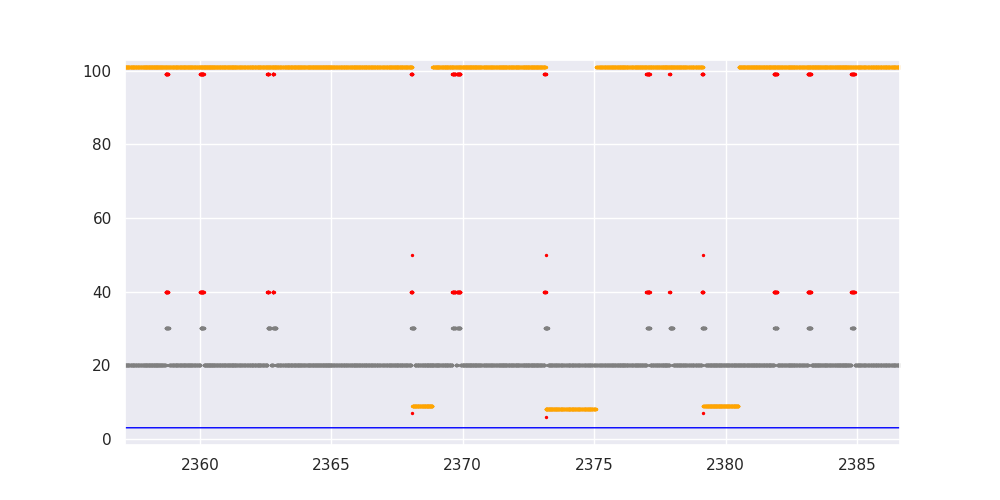

In [42]:
# plot to confirm that stim message is 500 msec after ripple (line up with lockout state)
# and to see how the merged changed the time stamps for stim message = 1
plt.figure(figsize=(10,5))
#realtime position with adjusted timestamp
plt.plot((decoder_data['bin_timestamp'].values)/30000,(((decoder_data['real_pos'].values)*1)/1),c='blue',linewidth=1)

#realtime ripples: stim message
plt.scatter(stim_message['bin_timestamp'].values/30000,((stim_message['shortcut_message_sent'].values)*10)+40,c='red',s=2)
plt.scatter(stim_message['bin_timestamp'].values/30000,((stim_message['posterior_max_arm'].values)*1)+0,c='red',s=2)
##plot lockout time
#plt.scatter(stim_lockout['timestamp'].values/30000,((stim_lockout['lockout_state'].values)*10)+35,c='k',s=2)

# merged decoder stim message - ripple end
plt.scatter(merged_decoder_lockout['bin_timestamp'].values/30000,((merged_decoder_lockout['posterior_max_arm'].values)*1)+2,c='orange',s=2)
## merged decoder lockout - ripple start
plt.scatter(merged_decoder_lockout['bin_timestamp'].values/30000,((merged_decoder_lockout['lockout_state'].values)*10)+20,c='grey',s=2)


In [14]:
# want to try to add both beginning of ripple and time bin when message was sent to decoder_data
stim_message1 = stim_message.copy()
stim_message2 = stim_message1.drop(['rec_ind','spike_timestamp','time',
                                   'ripple_number','ripple_time_bin',
                                   'content_threshold','max_arm_repeats','box','arm1','arm2',
                                   'arm3','arm4','arm5','arm6','arm7','arm8'], axis=1)
stim_message2
decode_to_merge = decoder_data.copy()
merged_decoder_stim = pd.merge_asof(decode_to_merge,stim_message2,on='bin_timestamp',direction='forward')
merged_decoder_stim

stim_lockout_1 = stim_lockout.copy()
stim_lockout_1['bin_timestamp'] = stim_lockout['timestamp']
stim_lockout_2 = stim_lockout_1.drop(['rec_ind','timestamp','time','lockout_num','tets_above_thresh','big_rip_message_sent'], axis=1)
stim_lockout_2
#decode_to_merge = decoder_data1.copy()
merged_decoder_lockout = pd.merge_asof(merged_decoder_stim,stim_lockout_2,on='bin_timestamp',direction='backward')
merged_decoder_lockout

,rec_ind,bin_timestamp,wall_time,velocity,real_pos,spike_count,ripple,ripple_number,ripple_length,shortcut_message,...,x68,x69,x70,x71,x72,lfp_timestamp,shortcut_message_sent,posterior_max_arm,ripple_end,lockout_state
0,1,126605700,1.577059e+09,233.993776,0.0,2,0,0,0,0,...,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,126606240.0,0.0,99.0,1.0,NaN
1,2,126605850,1.577059e+09,233.993776,0.0,2,0,0,0,0,...,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,126606240.0,0.0,99.0,1.0,NaN
2,3,126606150,1.577059e+09,233.993776,0.0,1,0,0,0,0,...,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,138073420.0,0.0,99.0,0.0,NaN
3,4,126606450,1.577059e+09,233.993776,0.0,1,0,0,0,0,...,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,138073420.0,0.0,99.0,0.0,NaN
4,5,126606600,1.577059e+09,233.131206,0.0,1,0,0,0,0,...,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,138073420.0,0.0,99.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394295,408357,199392900,1.577062e+09,3.367697,24.0,1,0,0,0,0,...,2.566465e-04,2.865070e-04,1.514040e-01,3.201128e-01,4.987452e-01,NaN,NaN,NaN,NaN,0.0
394296,408358,199393050,1.577062e+09,3.367697,24.0,0,0,0,0,0,...,3.707718e-04,5.046152e-02,1.564762e-01,3.216878e-01,4.368102e-01,NaN,NaN,NaN,NaN,0.0
394297,408359,199393200,1.577062e+09,3.367697,24.0,0,0,0,0,0,...,1.707070e-02,6.881074e-02,1.753096e-01,3.033628e-01,3.962762e-01,NaN,NaN,NaN,NaN,0.0
394298,408360,199393350,1.577062e+09,3.367697,24.0,0,0,0,0,0,...,2.872143e-02,8.666980e-02,1.815598e-01,2.900965e-01,3.633330e-01,NaN,NaN,NaN,NaN,0.0


<IPython.core.display.Javascript object>


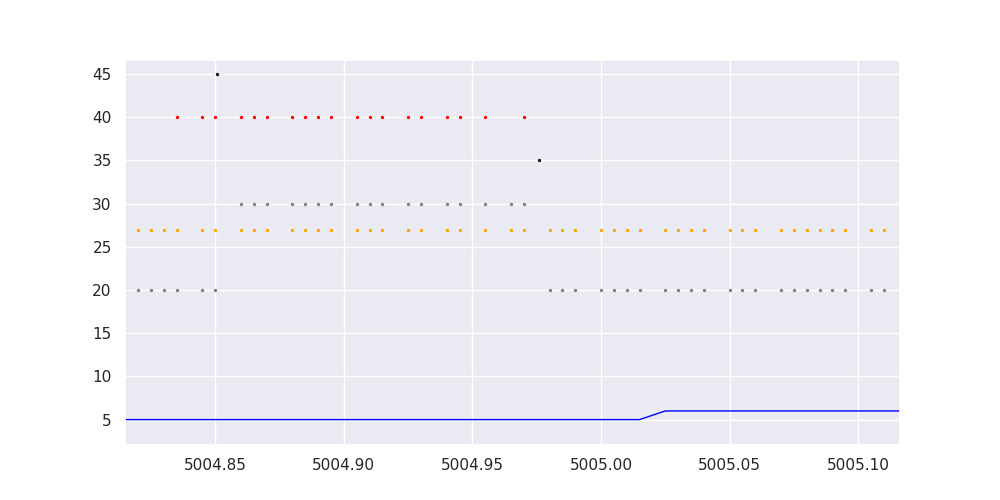

In [20]:
%matplotlib notebook
# plot to confirm that stim message is 500 msec after ripple (line up with lockout state)
# and to see how the merged changed the time stamps for stim message = 1
plt.figure(figsize=(10,5))
#realtime position with adjusted timestamp
plt.plot((decoder_data['bin_timestamp'].values)/30000,(((decoder_data['real_pos'].values)*1)/1),c='blue',linewidth=1)

#realtime ripples: stim message
plt.scatter(stim_message['bin_timestamp'].values/30000,((stim_message['shortcut_message_sent'].values)*10)+40,c='red',s=2)
#plot lockout time
plt.scatter(stim_lockout['timestamp'].values/30000,((stim_lockout['lockout_state'].values)*10)+35,c='k',s=2)

# merged decoder stim message - ripple end
plt.scatter(merged_decoder_lockout['bin_timestamp'].values/30000,((merged_decoder_lockout['shortcut_message_sent'].values)*10)+27,c='orange',s=2)
# merged decoder lockout - ripple start
plt.scatter(merged_decoder_lockout['bin_timestamp'].values/30000,((merged_decoder_lockout['lockout_state'].values)*10)+20,c='grey',s=2)


#plot velocity - zero at 15, cut-off for ripple detection
#plt.plot((decoder_data9['bin_timestamp'].values)/30000,(((decoder_data9['velocity'].values))/1),c='grey',linewidth=1)


<IPython.core.display.Javascript object>


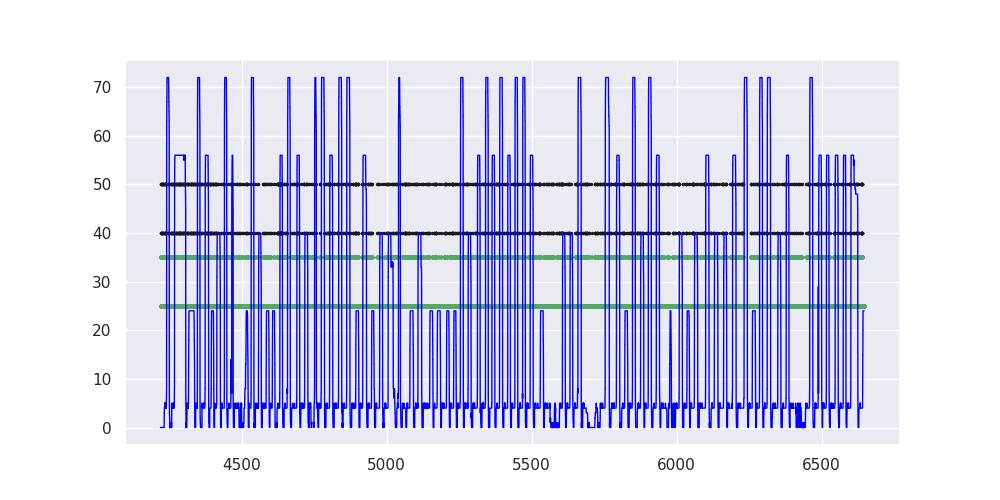

In [27]:
# plot to confirm that stim message is 500 msec after ripple (line up with lockout state)
# and to see how the merged changed the time stamps for stim message = 1
plt.figure(figsize=(10,5))
#realtime position with adjusted timestamp
plt.plot((decoder_data1['bin_timestamp'].values)/30000,(((decoder_data1['real_pos'].values)*1)/1),c='blue',linewidth=1)

#realtime ripples: stim message
#plt.scatter(stim_message['bin_timestamp'].values/30000,((stim_message['stim_sent'].values)*10)+40,c='red',s=2)

# merged decoder stim message
plt.scatter(merged_decoder_lockout['bin_timestamp'].values/30000,((merged_decoder_lockout['lockout_state'].values)*10)+25,c='g',s=2)

#ripple threshold
#plt.plot((ripple_data9['timestamp'].values)/30000,(((ripple_data9['ripple_threshold'].values)*3)/1),c='red',linewidth=1)

#plot lockout time
plt.scatter(stim_lockout1['timestamp'].values/30000,((stim_lockout1['lockout_state'].values)*10)+40,c='k',s=2)

#plot velocity - zero at 15, cut-off for ripple detection
#plt.plot((decoder_data9['bin_timestamp'].values)/30000,(((decoder_data9['velocity'].values))/1),c='grey',linewidth=1)


In [ ]:
plt.scatter(merged_decoder_stim['bin_timestamp'][9700:10000].values/30000,merged_decoder_stim['stim_sent'][9700:10000].values)
#plt.scatter(stim_message['bin_timestamp'][1000:1300].values/30000,stim_message['stim_sent'][1000:1300].values)


In [23]:
# subset of decoder_data to plot
#decoder_to_plot = decoder_data[(decoder_data['bin_timestamp'] > 205127400) & (decoder_data['bin_timestamp'] < 205636350)]
#decoder_to_plot.set_index('bin_timestamp',inplace=True)
#posterior_only = decoder_to_plot.drop(['rec_ind','wall_time','velocity','real_pos',
#                                       'spike_count','ripple','ripple_number','ripple_length',
#                                      'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
#                                      'arm6','arm7','arm8'], axis=1)

#posterior from decode/stim message merged table
merged_to_plot = merged_decoder_stim[(merged_decoder_stim['bin_timestamp'] > 205127400) & (merged_decoder_stim['bin_timestamp'] < 205636350)]
merged_to_plot.set_index('bin_timestamp',inplace=True)
posterior_only_merged = merged_to_plot.drop(['rec_ind','wall_time','velocity','real_pos',
                                            'spike_count','ripple','ripple_number','ripple_length',
                                            'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                                            'arm6','arm7','arm8','posterior_max_arm','stim_sent'], axis=1)
#posterior_only
posterior_only_merged
#decoder_to_plot.set_index('bin_timestamp',inplace=True)
#decoder_to_plot


,x00,x01,x02,x03,x04,x05,x06,x07,x08,x09,...,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72
bin_timestamp,,,,,,,,,,,,,,,,,,,,,
205127550,0.001192,0.001013,0.001147,0.001433,0.001563,0.001578,0.002206,0.003016,0.006808,0.0,...,0.048220,0.037324,0.073135,0.122442,0.185068,0.173513,0.106544,0.061503,0.029291,0.006295
205127700,0.001226,0.001211,0.001290,0.001472,0.001615,0.001871,0.002353,0.003584,0.008010,0.0,...,0.038326,0.052693,0.077293,0.126262,0.159532,0.154262,0.113307,0.065506,0.032279,0.013980
205127850,0.001313,0.001335,0.001416,0.001550,0.001743,0.002035,0.002687,0.004135,0.007760,0.0,...,0.041501,0.055885,0.085031,0.120443,0.145954,0.141660,0.110495,0.070065,0.037143,0.020065
205128150,0.000598,0.001382,0.001642,0.002331,0.001935,0.002729,0.003096,0.007052,0.011990,0.0,...,0.036547,0.037890,0.048314,0.122609,0.111309,0.143649,0.121626,0.076901,0.050551,0.010485
205128300,0.000475,0.000918,0.001412,0.001316,0.001344,0.001872,0.003555,0.005951,0.009766,0.0,...,0.056571,0.030498,0.080533,0.116801,0.139201,0.165888,0.091847,0.068471,0.037319,0.013050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205635300,0.188509,0.236966,0.184011,0.175251,0.107192,0.046119,0.006831,0.007341,0.001100,0.0,...,0.000877,0.001363,0.003092,0.001010,0.002172,0.001496,0.004043,0.000640,0.000654,0.000955
205635450,0.203597,0.202111,0.197717,0.154704,0.108998,0.053178,0.020083,0.005989,0.001808,0.0,...,0.001113,0.001867,0.001911,0.002179,0.001650,0.002655,0.002147,0.001868,0.000845,0.000949
205635600,0.202047,0.200103,0.183897,0.153036,0.105127,0.060508,0.026366,0.009894,0.001713,0.0,...,0.001352,0.001720,0.002074,0.002002,0.002249,0.002238,0.002310,0.001710,0.001313,0.001009


In [ ]:
ripples_to_plot = merged_to_plot.reset_index()
ripples_to_plot
ripple_times = ripples_to_plot.index[ripples_to_plot['stim_sent'] > 0].tolist()
ripple_times

In [37]:
stim_lockout

,rec_ind,timestamp,time,lockout_num,lockout_state,tets_above_thresh,ripple_cond_message_sent
0,9,174468760,2.620759e+02,0,0,2,0
1,10,174468780,2.620759e+02,0,0,2,0
2,11,174468920,2.620759e+02,0,0,2,0
3,12,174468940,2.620759e+02,0,0,2,0
4,13,174468940,2.620759e+02,0,0,2,0
...,...,...,...,...,...,...,...
2638,210976,281640540,1.576637e+09,835,0,0,0
2639,211388,281939380,6.618800e+00,836,1,2,0
2640,211527,281954400,1.576637e+09,836,0,0,0
2641,212138,282155780,3.546008e+00,837,1,2,0


<IPython.core.display.Javascript object>


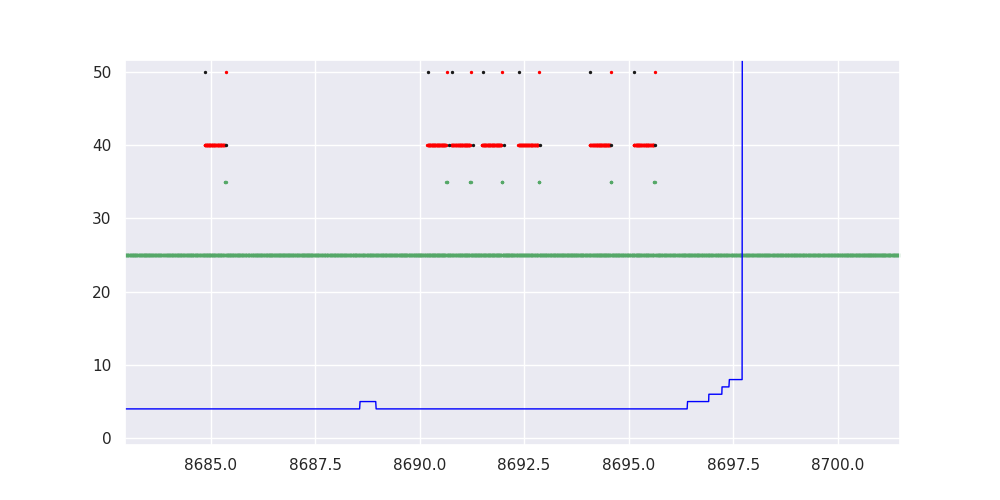

In [41]:
# plot to confirm that stim message is 500 msec after ripple (line up with lockout state)
# and to see how the merged changed the time stamps for stim message = 1
plt.figure(figsize=(10,5))
#realtime position with adjusted timestamp
plt.plot((decoder_data['bin_timestamp'].values)/30000,(((decoder_data['real_pos'].values)*1)/1),c='blue',linewidth=1)

#realtime ripples: stim message
plt.scatter(stim_message['bin_timestamp'].values/30000,((stim_message['stim_sent'].values)*10)+40,c='red',s=2)

# merged decoder stim message
plt.scatter(merged_decoder_stim['bin_timestamp'].values/30000,((merged_decoder_stim['stim_sent'].values)*10)+25,c='g',s=2)

#ripple threshold
#plt.plot((ripple_data9['timestamp'].values)/30000,(((ripple_data9['ripple_threshold'].values)*3)/1),c='red',linewidth=1)

#plot lockout time
plt.scatter(stim_lockout['timestamp'].values/30000,((stim_lockout['lockout_state'].values)*10)+40,c='k',s=2)

#plot velocity - zero at 15, cut-off for ripple detection
#plt.plot((decoder_data9['bin_timestamp'].values)/30000,(((decoder_data9['velocity'].values))/1),c='grey',linewidth=1)


In [52]:
stim_message1[stim_message1['ripple_end']==1]

,rec_ind,bin_timestamp,spike_timestamp,lfp_timestamp,time,shortcut_message_sent,ripple_number,ripple_time_bin,posterior_max_arm,content_threshold,...,max_arm_repeats,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8
0,1,126605850,126606194,126606240,1.577059e+09,0,0,0,99,0.5,...,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
11,3471,138074550,138075595,138075700,1.577060e+09,1,1,10,0,0.5,...,1,0.906853,0.008242,0.007692,0.061933,0.015279,0.0,0.0,0.0,0.0
22,3724,138383400,138384158,138384300,1.577060e+09,1,2,10,4,0.5,...,1,0.014089,0.019722,0.025151,0.033837,0.907201,0.0,0.0,0.0,0.0
33,3749,138390450,138390715,138390800,1.577060e+09,1,3,10,4,0.5,...,1,0.027573,0.034600,0.028070,0.051067,0.858690,0.0,0.0,0.0,0.0
54,3990,138633900,138634854,138634940,1.577060e+09,0,4,20,99,0.5,...,1,0.195683,0.174938,0.157852,0.242158,0.229369,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,82279,199151250,199157060,199157160,1.577062e+09,0,838,9,99,0.5,...,1,0.514029,0.055288,0.273203,0.095474,0.062005,0.0,0.0,0.0,0.0
10688,82312,199179750,199180052,199180240,1.577062e+09,1,839,10,0,0.5,...,1,0.670729,0.003119,0.004404,0.004048,0.317700,0.0,0.0,0.0,0.0
10722,82410,199189350,199194377,199194440,1.577062e+09,0,841,33,3,0.5,...,1,0.180104,0.047266,0.116917,0.522499,0.133214,0.0,0.0,0.0,0.0
10741,82455,199218300,199218944,199219120,1.577062e+09,0,842,18,3,0.5,...,1,0.020768,0.015887,0.296846,0.508768,0.157730,0.0,0.0,0.0,0.0


In [59]:
stim_message1[10705:10715]

,rec_ind,bin_timestamp,spike_timestamp,lfp_timestamp,time,shortcut_message_sent,ripple_number,ripple_time_bin,posterior_max_arm,content_threshold,...,max_arm_repeats,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8
10705,82349,199186500,199186694,199186880,1.577062e+09,0,840,17,99,0.5,...,1,0.051556,0.021081,0.216927,0.688206,0.022230,0.0,0.0,0.0,0.0
10706,82350,199186650,199186835,199187020,1.577062e+09,0,840,18,99,0.5,...,1,0.056618,0.021921,0.187224,0.708634,0.025603,0.0,0.0,0.0,0.0
10707,82351,199186800,199186996,199187060,1.577062e+09,0,840,19,99,0.5,...,1,0.054837,0.023364,0.192904,0.700891,0.028004,0.0,0.0,0.0,0.0
10708,82359,199186950,199187194,199187300,1.577062e+09,0,840,20,99,0.5,...,1,0.099402,0.028695,0.165799,0.649894,0.056210,0.0,0.0,0.0,0.0
10709,82370,199187100,199187273,199188180,1.577062e+09,0,841,21,99,0.5,...,1,0.071620,0.031247,0.179995,0.653514,0.063624,0.0,0.0,0.0,0.0
10710,82372,199187250,199187441,199188260,1.577062e+09,0,841,22,99,0.5,...,1,0.085884,0.027732,0.149108,0.669808,0.067468,0.0,0.0,0.0,0.0
10711,82373,199187400,199187598,199188280,1.577062e+09,0,841,23,99,0.5,...,1,0.056406,0.021168,0.148298,0.700635,0.073493,0.0,0.0,0.0,0.0
10712,82374,199187550,199187713,199188400,1.577062e+09,0,841,24,99,0.5,...,1,0.061908,0.021905,0.133331,0.711492,0.071364,0.0,0.0,0.0,0.0
10713,82378,199187700,199187959,199188480,1.577062e+09,0,841,25,99,0.5,...,1,0.051074,0.024564,0.140960,0.713077,0.070325,0.0,0.0,0.0,0.0
10714,82383,199187850,199188055,199188520,1.577062e+09,0,841,26,99,0.5,...,1,0.035442,0.012394,0.130820,0.751616,0.069728,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>


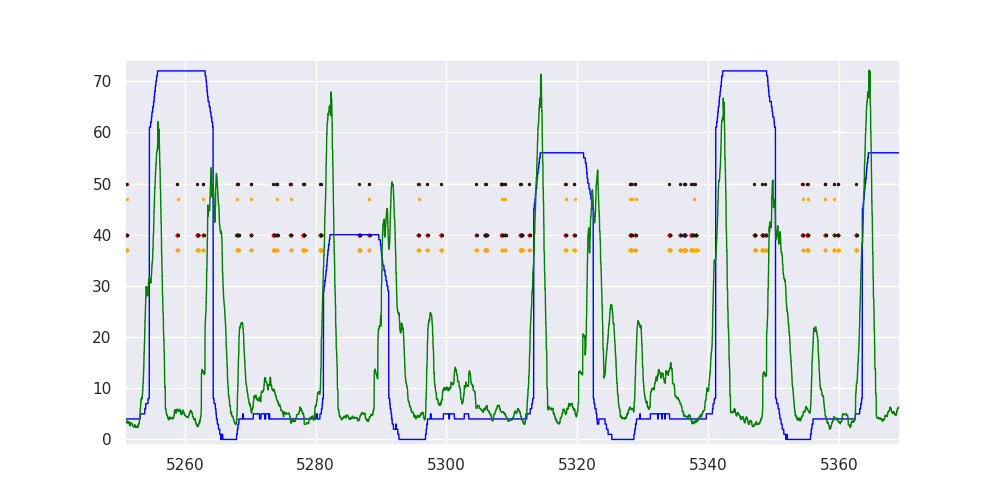

In [51]:
# look at time delay for stim message with new posterior sum function

plt.figure(figsize=(10,5))
#realtime position with adjusted timestamp
plt.plot((decoder_data1['bin_timestamp'].values)/30000,(((decoder_data1['real_pos'].values)*1)/1),c='blue',linewidth=1)
plt.plot((decoder_data1['bin_timestamp'].values)/30000,(((decoder_data1['velocity'].values)*1)/1),c='green',linewidth=1)


#realtime ripples: stim message
plt.scatter(stim_message1['bin_timestamp'].values/30000,((stim_message1['shortcut_message_sent'].values)*10)+40,c='red',s=2)
plt.scatter(stim_message1['lfp_timestamp'].values/30000,((stim_message1['shortcut_message_sent'].values)*10)+37,c='orange',s=2)

# merged decoder stim message
#plt.scatter(merged_decoder_stim['bin_timestamp'].values/30000,((merged_decoder_stim['stim_sent'].values)*10)+25,c='g',s=2)

#ripple threshold
#plt.plot((ripple_data9['timestamp'].values)/30000,(((ripple_data9['ripple_threshold'].values)*3)/1),c='red',linewidth=1)

#plot lockout time
plt.scatter(stim_lockout1['timestamp'].values/30000,((stim_lockout1['lockout_state'].values)*10)+40,c='k',s=2)

#plot velocity - zero at 15, cut-off for ripple detection
#plt.plot((decoder_data9['bin_timestamp'].values)/30000,(((decoder_data9['velocity'].values))/1),c='grey',linewidth=1)


<IPython.core.display.Javascript object>


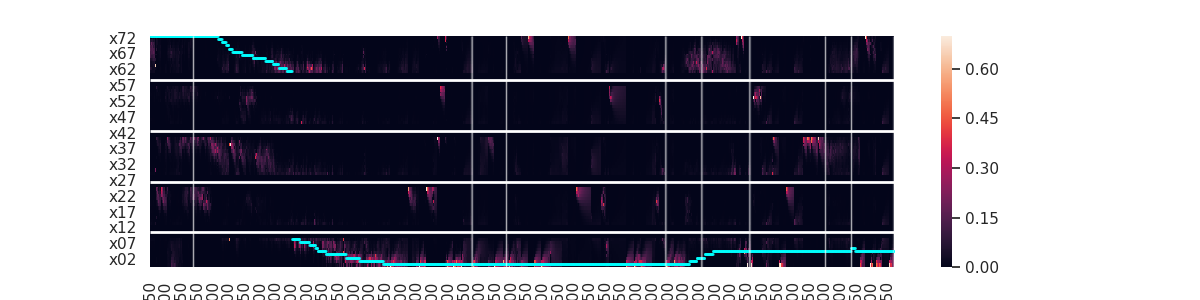

In [33]:
%matplotlib notebook
# all tetrodes (21) for full session on drought, 150 uV threshold, good linearization, adjusted TS
# 20 tetrodes for full session on drought, 150 uV threshold, adjusted timestamps
# realtime arm ends: 1, 17, 33, 49, 65, 81, 97, 113, 129
# new arm ends: 7, 23, 39, 55, 71, 87, 103, 119, 135
import seaborn as sns
sns.set()

#ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] > 0].tolist()
#this value is currently just emprically set
#ripple_timestamps = posterior_to_plot[posterior_to_plot['ripple_grp'] > 0]['timestamp'].values - 1958800
#closest value lookup, return row
#decoder_ripple_times = decoder_to_plot.iloc[(decoder_to_plot['timestamp']-ripple_timestamps[0]).abs().argsort()[:1]]
#for i in np.arange(1,ripple_timestamps.shape[0]):
#    ripple_row = decoder_to_plot.iloc[(decoder_to_plot['timestamp']-ripple_timestamps[i]).abs().argsort()[:1]]
#    decoder_ripple_times = decoder_ripple_times.append(ripple_row)
    #print(i)
#decoder_ripple_times
#decoder_ripple_list = decoder_ripple_times.index.tolist()

#posterior_only = decoder_to_plot.drop(['rec_ind','timestamp','real_pos_time','real_pos','spike_count','adj_timestamp'], axis=1)

post_heatmap = posterior_only_merged.transpose()
post_heatmap = post_heatmap.iloc[::-1]

plt.figure(figsize=(12,3))
ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
#gap lines need to be inverse of where you would expect
ax.hlines([135-9,135-25,135-41,135-57,135-73,135-89,135-105,135-121], lw=2, color='w',*ax.get_xlim())
ax.scatter(np.arange(0,merged_to_plot.shape[0]),72-merged_to_plot['real_pos'].values,s=1,alpha=0.5,color='cyan')
#ax.scatter(stim_lockout['timestamp'].values,(stim_lockout['lockout_state'].values)*50,s=2,alpha=1)
ax.vlines(ripple_times,lw=1,color='w',alpha=0.3,*ax.get_ylim())
# some how need to convert sent_message_list into values starting where beginning of this plot is x=0
#ax.vlines(100,lw=1,color='w',alpha=1,*ax.get_ylim())


In [ ]:
#plot realtime data no ripple
import seaborn as sns
sns.set()

posterior_only = decoder_to_plot.drop(['rec_ind','timestamp','real_pos_time','real_pos','spike_count','adj_timestamp'], axis=1)

post_heatmap = posterior_only.transpose()
post_heatmap = post_heatmap.iloc[::-1]

plt.figure(figsize=(15,5))
ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
#gap lines need to be inverse of where you would expect
ax.hlines([135-9,135-25,135-41,135-57,135-73,135-89,135-105,135-121], lw=2, color='w',*ax.get_xlim())

# save posterior heatmap for all ripples - realtime

In [ ]:
# make indivudal posterior heatmap for each detected ripple
# shifted realtime rips back 70 msec to take care of delay in detection
# to match offline: +/- 100 msec after trigger
# also plot end of posterior lockout to see how much of the ripple is missed by sum
# loop through timestamp for each ripple and generate a new slice of decoder data
# plot that slice then save image

(array([ 0., 22., 11.,  8., 17., 43., 48., 52.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 8 Patch objects>)

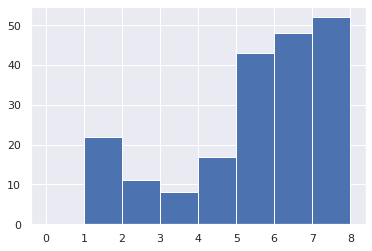

In [71]:
plt.hist(stim_message['posterior_max_arm'].values,bins=np.arange(0,9))

In [167]:
#plt.hist(stim_message2['posterior_max_arm'].values,bins=np.arange(0,9))
stim_message2[stim_message2['posterior_max_arm']==99]
stim_message2[140:150]
target_time = 80766160
stim_message2[(stim_message2['lfp_timestamp']>target_time-200000) & (stim_message2['lfp_timestamp']<target_time+200000)]


,rec_ind,bin_timestamp,spike_timestamp,lfp_timestamp,time,shortcut_message_sent,ripple_number,ripple_time_bin,spike_count,posterior_max_arm,...,max_arm_repeats,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8
182,122079,80593200,80593360,80593440,1.580672e+09,0,154,1,5,0,...,1,0.968147,0.000813,0.006544,0.000502,0.000851,0.005418,0.006296,0.009275,0.002155
183,122173,80617650,80617988,80618020,1.580672e+09,0,155,1,1,0,...,1,0.918858,0.005445,0.011303,0.000960,0.002369,0.004687,0.004474,0.010212,0.041692
184,122578,80761500,80761665,80761740,1.580672e+09,1,156,1,3,7,...,1,0.052384,0.023777,0.298800,0.002287,0.003019,0.047482,0.013506,0.557120,0.001625
185,122629,80766000,80766172,80766200,1.580672e+09,0,157,1,7,0,...,1,0.782780,0.078628,0.136533,0.000029,0.000107,0.000185,0.000947,0.000764,0.000029
186,122801,80814450,80814674,80814760,1.580672e+09,0,158,1,5,0,...,1,0.788240,0.042204,0.036477,0.111869,0.002478,0.000612,0.000671,0.014541,0.002908
187,122821,80817300,80817459,80817560,1.580672e+09,1,158,20,76,8,...,1,0.271207,0.053294,0.002368,0.001031,0.005538,0.000443,0.042822,0.057184,0.566114
188,123011,80885850,80886026,80886100,1.580672e+09,0,159,1,8,0,...,1,0.678107,0.012744,0.002105,0.040394,0.005941,0.026760,0.189625,0.023187,0.021137
189,123111,80919450,80919614,80919680,1.580672e+09,0,160,1,2,0,...,1,0.901241,0.000518,0.000608,0.001295,0.000588,0.000910,0.001456,0.044300,0.049084
190,123259,80964600,80965060,80965520,1.580672e+09,0,161,1,4,0,...,1,0.941381,0.000746,0.000810,0.004589,0.001620,0.002936,0.034682,0.011770,0.001465


In [164]:
stim_lockout2[stim_lockout2['lockout_state']>0][157:162]

,rec_ind,timestamp,time,lockout_num,lockout_state,tets_above_thresh,big_rip_message_sent
467,122077,80593400,3.979147,157,1,2,0
470,122166,80617880,3.989685,158,1,2,0
473,122575,80761640,5.375251,159,1,2,0
475,122627,80766160,5.409420,160,1,3,0
479,122800,80814760,4.062650,161,1,2,0


In [536]:
timestamp = 80766160
merge_subset = merged_decoder_lockout[(merged_decoder_lockout['bin_timestamp'] > timestamp-30*300) & 
                                      (merged_decoder_lockout['bin_timestamp'] < timestamp+30*300)]
#merge_subset['posterior_max_arm'].values
#merge_subset['lockout_num'].values
merge_subset['lockout_state'].values
merged_decoder_lockout[1000:1010]

,rec_ind,bin_timestamp,wall_time,velocity,real_pos,raw_x,raw_y,smooth_x,smooth_y,spike_count,...,x135,x136,shortcut_message_sent,ripple_number_y,delay,posterior_max_arm,ripple_end,lockout_num,lockout_state,timestamp_shift
1000,2352,39855000,1.580922e+09,4.696132,3.0,694.0,383.0,693.9191,382.5315,4,...,1.707080e-14,1.707080e-14,0,5,38.0,0,0,2.0,1.0,39854960.0
1001,2356,39855150,1.580922e+09,4.696132,3.0,694.0,383.0,693.9191,382.5315,6,...,1.467740e-15,1.467740e-15,0,5,38.0,0,0,2.0,1.0,39854960.0
1002,2358,39855300,1.580922e+09,4.696132,3.0,694.0,383.0,693.9191,382.5315,1,...,7.506991e-20,7.506991e-20,0,5,38.0,0,0,2.0,1.0,39854960.0
1003,2360,39855450,1.580922e+09,4.696132,3.0,694.0,383.0,693.9191,382.5315,3,...,9.896773e-05,9.896773e-05,0,5,38.0,0,0,2.0,1.0,39854960.0
1004,2364,39855600,1.580922e+09,4.696132,3.0,694.0,383.0,693.9191,382.5315,7,...,1.147196e-17,1.147196e-17,0,5,38.0,0,0,2.0,1.0,39854960.0
1005,2366,39855750,1.580922e+09,4.808794,3.0,694.0,384.0,693.9205,382.5767,3,...,2.468516e-26,2.468516e-26,0,5,38.0,0,0,2.0,1.0,39854960.0
1006,2368,39855900,1.580922e+09,4.808794,3.0,694.0,384.0,693.9205,382.5767,0,...,9.896782e-05,9.896782e-05,0,5,38.0,0,0,2.0,1.0,39854960.0
1007,2370,39856050,1.580922e+09,4.808794,3.0,694.0,384.0,693.9205,382.5767,4,...,1.145830e-10,1.145830e-10,0,5,38.0,0,0,2.0,1.0,39854960.0
1008,2373,39856200,1.580922e+09,4.808794,3.0,694.0,384.0,693.9205,382.5767,1,...,5.423223e-18,5.423223e-18,0,5,38.0,0,0,2.0,1.0,39854960.0
1009,2376,39856350,1.580922e+09,4.808794,3.0,694.0,384.0,693.9205,382.5767,4,...,9.896791e-05,9.896791e-05,0,5,38.0,0,0,2.0,1.0,39854960.0


In [561]:
# want to try to add both beginning of ripple and time bin when message was sent to decoder_data
# for stim_message this merge ('nearest') put the arm number and ripple number at all timebins after the end of the rippple
# for stim_lockout this merge ('backward') will highlight the ripple time
# stim_lockout timestamp_shift is the 70 msec shift to account for delay in realtime rip detection (-2100)

stim_message_1 = stim_message14.copy()
stim_message_2 = stim_message_1.drop(['rec_ind','spike_timestamp','time','lfp_timestamp',
                                   'ripple_time_bin','spike_count',
                                   'content_threshold','max_arm_repeats','box','arm1','arm2',
                                   'arm3','arm4','arm5','arm6','arm7','arm8'], axis=1)
stim_message_2
decode_to_merge = decoder_data14.copy()
merged_decoder_stim = pd.merge_asof(decode_to_merge,stim_message_2,on='bin_timestamp',direction='nearest')
merged_decoder_stim

stim_lockout_1 = stim_lockout14.copy()
#stim_lockout_1['bin_timestamp'] = stim_lockout14['timestamp']
stim_lockout_1['timestamp_shift'] = stim_lockout14['timestamp']
stim_lockout_1['bin_timestamp'] = stim_lockout_1['timestamp_shift']

stim_lockout_2 = stim_lockout_1.drop(['rec_ind','timestamp','time','tets_above_thresh','big_rip_message_sent'], axis=1)
stim_lockout_2
##decode_to_merge = decoder_data1.copy()
merged_decoder_lockout = pd.merge_asof(merged_decoder_stim,stim_lockout_2,on='bin_timestamp',direction='backward')
merged_decoder_lockout.shape

(784686, 169)

In [544]:
stim_lockout14[stim_lockout14['lockout_state']==1]['timestamp'][5:15]

10    42054220
13    42709680
16    43895760
19    44082520
22    45317800
24    45322320
28    45327040
31    45530460
34    45629260
37    45900320
Name: timestamp, dtype: int64

In [559]:
#timestamp =   45327040  
#shortcut_message_to_plot = stim_message14[(stim_message14['bin_timestamp'] > timestamp-30*30) & 
#                                             (stim_message14['bin_timestamp'] < timestamp+30*100)]
shortcut_message_to_plot
#merged_to_plot[55:65]

,rec_ind,bin_timestamp,spike_timestamp,lfp_timestamp,time,shortcut_message_sent,ripple_number,ripple_time_bin,delay,spike_count,...,max_arm_repeats,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8
9,18176,45900000,45900319,45900360,1.580922e+09,0,14,1,12.0,8,...,1,0.999099,0.000168,0.00013,0.000027,0.000123,0.000002,0.000047,1.063372e-14,0.000404


In [ ]:
# subset of decoder_data to plot - loop through each ripple
# how can we just generate the images for the mismatched ripples??

realtime_posterior_sum_all = np.zeros((len(stim_lockout14[stim_lockout14['lockout_state']==1]),4))
counter = -1

for timestamp in stim_lockout14[stim_lockout14['lockout_state']==1]['timestamp'].values:
    counter += 1
    #print(counter)
    if counter in non_matching['realtime_rip'].values:
        print(counter)
    #print(timestamp-30*300,timestamp+30*300)
    #posterior from decode/stim message merged table
        merged_to_plot = merged_decoder_lockout[(merged_decoder_lockout['bin_timestamp'] > timestamp-30*300) & 
                                            (merged_decoder_lockout['bin_timestamp'] < timestamp+30*300)]
        merged_to_plot.set_index('bin_timestamp',inplace=True)

        posterior_only_merged = merged_to_plot.drop(['rec_ind','wall_time','velocity','real_pos',
                                                'spike_count','ripple','ripple_length','timestamp_shift',
                                                'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                                                'arm6','arm7','arm8','posterior_max_arm','shortcut_message_sent',
                                                'raw_x','raw_y','smooth_x','smooth_y','ripple_number_x',
                                                'ripple_number_y','ripple_end','lockout_state','lockout_num',
                                                'delay','next_bin'], axis=1)
        # ripple time - generated from lockout_state
        # lockout_state changes at posterior_lock end, so this should post_lock (now 50 msec)
        ripples_to_plot = merged_to_plot.reset_index()
        ripple_times_rt = ripples_to_plot.index[ripples_to_plot['lockout_state'] > 0].tolist()

        # get timestamp when shortcut message was sent - try to just isolate single ripple
        # bin_timestamp will show the delay - it will appear before the start of the ripple
        # in contrast, lfp_timestamp would line up exactly with ripple start
        shortcut_message_to_plot = stim_message14[(stim_message14['bin_timestamp'] > timestamp-30*30) & 
                                             (stim_message14['bin_timestamp'] < timestamp+30*100)]
        merged_to_plot_index = merged_to_plot.reset_index()
        # loop through multiple entries in shortcut_message
        shortcut_message_times = np.zeros(shortcut_message_to_plot.shape[0])
        for i in np.arange(0,shortcut_message_to_plot.shape[0]):
            shortcut_message_times[i] = merged_to_plot_index.index[merged_to_plot_index['bin_timestamp'].values == shortcut_message_to_plot['bin_timestamp'][i:i+1].values].tolist()[0]
        #shortcut_message_times = merged_to_plot_index.index[merged_to_plot_index['bin_timestamp'].values == shortcut_message_to_plot['bin_timestamp'].values].tolist()
        shortcut_messages = shortcut_message_to_plot['shortcut_message_sent'].values*123
    
        #posterior_only
        #print(posterior_only_merged.shape)
    
        #plot heatmap with posterior surrounding each ripple
        post_heatmap = posterior_only_merged.transpose()
        post_heatmap = post_heatmap.iloc[::-1]
    
        #plot title: include ripple number, max arm, and delay
        title_index = int(len(merged_to_plot)*0.6)
        max_arm = merged_to_plot[title_index:title_index+1]['posterior_max_arm'].values
        #ripple_num = merged_to_plot[-2:-1]['ripple_number_y'].values
        #f'Real-time posterior, ripple {max_arm}. Max arm {ripple_num}'
        #ripple_num = merged_to_plot[ripple_num_index:ripple_num_index+1]['ripple_number_y'].values
        ripple_num = merged_to_plot[title_index:title_index+1]['lockout_num'].values
        message_delay = np.around(merged_to_plot[title_index:title_index+1]['delay'].values,decimals=0)

        # fill in current row of posterior sum array - seems to work
        realtime_posterior_sum_all[counter,0] = ripple_num
        realtime_posterior_sum_all[counter,1] = max_arm
        realtime_posterior_sum_all[counter,2] = shortcut_message_to_plot.shape[0]-1
        realtime_posterior_sum_all[counter,3] = message_delay
    
        plt.figure(figsize=(12,5))
        plt.title(f'Real-time posterior, Ripple {ripple_num} Max arm {max_arm} Delay {message_delay}')
        ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
        #gap lines need to be inverse of where you would expect
        ax.hlines([135-9,135-25,135-41,135-57,135-73,135-89,135-105,135-121], lw=2, color='w',*ax.get_xlim())
        ax.scatter(np.arange(0,merged_to_plot.shape[0]),136-merged_to_plot['real_pos'].values,s=1,alpha=0.5,color='cyan')
        #ax.scatter(stim_lockout['timestamp'].values,(stim_lockout['lockout_state'].values)*50,s=2,alpha=1)
        ax.vlines(ripple_times_rt,lw=1,color='w',alpha=0.3,*ax.get_ylim())
        # plot time when statescript message was sent, 100 = sent, 0 = not send
        # if X is missing it means the timestamp didn't match perfectly above
        # could take delay into account here: add delay/5
        ax.scatter(shortcut_message_times+message_delay/5,124-shortcut_messages,s=40,color='yellow',marker='x')

        # try to find ripple number
        #ax.scatter(np.arange(0,merged_to_plot.shape[0]),136-merged_to_plot['ripple_number_y'].values+20,s=1,alpha=0.5,color='red')
        # need to convert sent_message_list into values starting where beginning of this plot is x=0
        #ax.vlines(100,lw=1,color='w',alpha=1,*ax.get_ylim())
    
        # final step: save the figure
        #plt.savefig(f'/stelmo/mcoulter/posterior_plots_by_ripple/2-4-20/remy_20_2_realtime_2_5_nonmatching_{ripple_num}_timestamp_{timestamp}.jpg')

# convert offline_posterior_sum_all array to pandas
realtime_post_sum_summary = pd.DataFrame(data=realtime_posterior_sum_all,columns=('realtime_rip','rt_max_arm',
                                                                                  'rt_two_messages','rt_delay'))
realtime_post_sum_summary.shape
# check numbering for ripples 4, 5, 6
# also, looks like it never switch to an outer arm if the decode starts in the box
# looks like many replays fail because it doesn't get 10 bins of data - this may be a result of empty bins

In [519]:
# to match offline, add 1958987 to realtime timestamps
# shift for realtime ripple detection delay: subtract 2100
#45317550 45321300

realtime_rips = stim_lockout14[stim_lockout14['lockout_state']==1]
offline_rips = rips.reset_index()
offline_rips['adj_timestamp'] = offline_rips['timestamp']
realtime_rips['adj_timestamp'] = realtime_rips['timestamp']+1958987-2100
realtime_rips
# merge real-time and offline ripples 
# offline ripple start is 50-100 msec before real-time
# try a tolerance of 100 msec = 3000 timestamps
merged_ripple_times = pd.merge_asof(offline_rips,realtime_rips,on='adj_timestamp',tolerance=3000,direction='nearest')
matching_offline_rips = merged_ripple_times[merged_ripple_times['lockout_num']>0]
matching_offline_rips.shape

(452, 15)

(array([ 12., 351.,  74.,  14.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

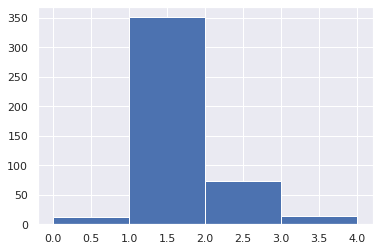

In [499]:
# shows number of offline ripples that match two realtime ripples (duplicates)
# look at value of 0 bin in histogram (23)
plt.hist(matching_offline_rips['lockout_num'].diff().values,bins=np.arange(0,5))

In [587]:
matching_offline_rips
for index, rip_timestamp in enumerate(matching_offline_rips['timestamp_x'][0:10]):
    if matching_offline_rips['lockout_num'][index:index+1].values in non_matching['realtime_rip'].values:
        print(matching_offline_rips['lockout_num'][index:index+1].values)

[11.]
[11.]
[12.]
[14.]
[15.]


In [588]:
non_matching

,realtime_rip,offline_rip,realtime_ripoff,off_max_arm,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8,realtime_riprt,rt_max_arm,rt_two_messages,rt_delay
3,11.0,87.0,11.0,99.0,0.3,0.0,0.0,0.2,0.1,0.1,0.0,0.0,0.1,11.0,0.0,0.0,11.0
4,11.0,88.0,11.0,99.0,0.4,0.0,0.0,0.0,0.0,0.0,0.4,0.1,0.0,11.0,0.0,0.0,11.0
5,12.0,89.0,12.0,0.0,0.7,0.0,0.0,0.0,0.1,0.2,0.0,0.0,0.0,12.0,1.0,0.0,12.0
7,14.0,96.0,14.0,8.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,14.0,0.0,0.0,12.0
8,15.0,98.0,15.0,0.0,0.5,0.0,0.1,0.0,0.0,0.1,0.0,0.2,0.0,15.0,1.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,543.0,2141.0,543.0,3.0,0.2,0.0,0.0,0.5,0.0,0.0,0.0,0.1,0.2,543.0,8.0,0.0,14.0
447,544.0,2144.0,544.0,0.0,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,544.0,99.0,-1.0,39.0
448,547.0,2161.0,547.0,0.0,0.6,0.0,0.2,0.0,0.0,0.1,0.0,0.0,0.0,547.0,2.0,0.0,14.0
449,548.0,2164.0,548.0,7.0,0.2,0.0,0.0,0.0,0.0,0.0,0.3,0.5,0.0,548.0,0.0,0.0,13.0


In [ ]:
# offline posteriors, 150 uV threshold
#offline arm ends 8, 25, 42, 59, 77, 94, 111, 128, 145 
arm_coords = [[0,8],[13,25],[30,42],[47,59],[65,77],[82,94],[99,111],[116,128],[133,145]]

# now need to plot offline ripples that are mismatched

posterior_offline = posteriors2.reset_index()
offline_pos = binned_linear_pos.reset_index()
merged_off_post_pos = pd.merge_asof(posterior_offline,offline_pos,on='timestamp',direction='nearest')
offline_posterior_sum_all = np.zeros((len(matching_offline_rips),12))

for index, rip_timestamp in enumerate(matching_offline_rips['timestamp_x']):
    if matching_offline_rips['lockout_num'][index:index+1].values in non_matching['realtime_rip'].values:
        print(matching_offline_rips['lockout_num'][index:index+1].values)
        #print(rip_timestamp-30*300,rip_timestamp+30*300,index)

        posterior_to_plot = merged_off_post_pos[(merged_off_post_pos['timestamp'] > rip_timestamp-30*300) & 
                                            (merged_off_post_pos['timestamp'] < rip_timestamp+30*300)]

        realtime_ripple_num = matching_offline_rips['lockout_num'][index:index+1].values
        ripple_num_index = int(len(posterior_to_plot)*0.55)
        ripple_num = posterior_to_plot[ripple_num_index:ripple_num_index+1]['ripple_grp'].values
    
        # calculate posterior sum during ripple
        # we need to only take out the time when ripple_grp matches ripple_grp at the middle of the plotting bin
    
        #post_sum_times = posterior_to_plot[posterior_to_plot['ripple_grp'] > 0]
        post_sum_times = posterior_to_plot[posterior_to_plot['ripple_grp'] == ripple_num[0]]
        ripple_length = post_sum_times.shape[0]
        # sum each arm over whole ripple
        post_sum_ripple = np.zeros((ripple_length,9))
        for i in np.arange(0,ripple_length):
            if i == 0:
                for j in np.arange(0,len(arm_coords),1):
                    post_sum_ripple[i,j] = post_sum_times.iloc[i,4:150].values[arm_coords[j][0]:arm_coords[j][1]].sum()

            else:
                for j in np.arange(0,len(arm_coords),1):
                    post_sum_ripple[i,j] = post_sum_ripple[i-1,j] + post_sum_times.iloc[i,4:150].values[arm_coords[j][0]:arm_coords[j][1]].sum()
            
        # normalize sum of whole ripple - this is the final row
        post_sum_ripple[i] = post_sum_ripple[i]/post_sum_ripple[i].sum()
    
        ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] > 0].tolist()

        posterior_offline1 = posterior_to_plot.drop(['day_x','epoch_x','timestamp','time_x','num_spikes','dec_bin',
                                                 'ripple_grp','day_y','epoch_y','time_y','linpos_flat',
                                                 'linvel_flat'], axis=1)

        posterior_offline2 = posterior_offline1.fillna(0)
        post_heatmap = posterior_offline2.transpose()
        post_heatmap = post_heatmap.iloc[::-1]

        posterior_sum = np.around(post_sum_ripple[-1:],decimals=1)
        posterior_sum = posterior_sum[0]
    
        if len(np.argwhere(posterior_sum>=0.5)):
            arm_max = np.argwhere(posterior_sum>=0.5)[0][0]
        else:
            arm_max = 99 

        # fill in current row of posterior sum array - seems to work
        offline_posterior_sum_all[index,0] = ripple_num
        offline_posterior_sum_all[index,1] = realtime_ripple_num
        offline_posterior_sum_all[index,2] = arm_max
        offline_posterior_sum_all[index,3] = posterior_sum[0]
        offline_posterior_sum_all[index,4] = posterior_sum[1]
        offline_posterior_sum_all[index,5] = posterior_sum[2]
        offline_posterior_sum_all[index,6] = posterior_sum[3]
        offline_posterior_sum_all[index,7] = posterior_sum[4]
        offline_posterior_sum_all[index,8] = posterior_sum[5]
        offline_posterior_sum_all[index,9] = posterior_sum[6]
        offline_posterior_sum_all[index,10] = posterior_sum[7]
        offline_posterior_sum_all[index,11] = posterior_sum[8]
                                     
        plt.figure(figsize=(12,5))
        plt.title(f'Off rip {ripple_num}. RT rip {realtime_ripple_num} Arm {arm_max} {posterior_sum}')
        ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
        ax.hlines([145-10,145-27,145-44,145-61,145-79,145-96,145-113,145-130], lw=2, color='w',*ax.get_xlim())
        ax.scatter(np.arange(0,posterior_to_plot.shape[0]),145-posterior_to_plot['linpos_flat'].values,s=2,alpha=1,color='cyan')
        ax.vlines([ripple_times-posterior_to_plot.index[0]],lw=1,color='w',alpha=0.2,*ax.get_ylim())
    
        # final step: save the figure
        #plt.savefig(f'/stelmo/mcoulter/posterior_plots_by_ripple/2-4-20/remy_20_2_offline_rip_nonmatching_{ripple_num}_real_rip_{realtime_ripple_num}_timestamp_{rip_timestamp}.jpg')

# convert offline_posterior_sum_all array to pandas
off_post_sum_summary = pd.DataFrame(data=offline_posterior_sum_all,columns=('offline_rip','realtime_rip',
                                                                            'off_max_arm','box','arm1','arm2',
                                                                            'arm3','arm4','arm5','arm6',
                                                                            'arm7','arm8'))

off_post_sum_summary.shape

(452, 17)


(array([ 12., 351.,  74.,  11.,   3.,   0.,   0.,   0.,   0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

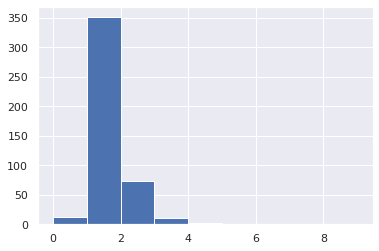

In [529]:
# join offline and realtime replay summaries
replay_summary_combined = pd.DataFrame.join(off_post_sum_summary,realtime_post_sum_summary,on='realtime_rip',
                                            how='outer',lsuffix='off',rsuffix='rt')
replay_combined_matching = replay_summary_combined[replay_summary_combined['offline_rip']>0]
#replay_combined_matching = replay_combined_matching[replay_combined_matching['rt_two_messages']<1]
#replay_summary_combined['realtime_ripoff'].values
print(replay_combined_matching.shape)
plt.hist(replay_combined_matching['realtime_rip'].diff(),bins=np.arange(0,10))

In [538]:
non_matching = replay_combined_matching[replay_combined_matching['off_max_arm'].values != replay_combined_matching['rt_max_arm'].values]
non_matching
#non_matching[non_matching['rt_max_arm'] == 6]
#replay_combined_matching[replay_combined_matching['rt_two_messages']>0]
#for i in np.arange(0,50):
#    if i in non_matching['realtime_rip'].values:
#        print(i)

,realtime_rip,offline_rip,realtime_ripoff,off_max_arm,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8,realtime_riprt,rt_max_arm,rt_two_messages,rt_delay
3,11.0,87.0,11.0,99.0,0.3,0.0,0.0,0.2,0.1,0.1,0.0,0.0,0.1,11.0,0.0,0.0,11.0
4,11.0,88.0,11.0,99.0,0.4,0.0,0.0,0.0,0.0,0.0,0.4,0.1,0.0,11.0,0.0,0.0,11.0
5,12.0,89.0,12.0,0.0,0.7,0.0,0.0,0.0,0.1,0.2,0.0,0.0,0.0,12.0,1.0,0.0,12.0
7,14.0,96.0,14.0,8.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,14.0,0.0,0.0,12.0
8,15.0,98.0,15.0,0.0,0.5,0.0,0.1,0.0,0.0,0.1,0.0,0.2,0.0,15.0,1.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,543.0,2141.0,543.0,3.0,0.2,0.0,0.0,0.5,0.0,0.0,0.0,0.1,0.2,543.0,8.0,0.0,14.0
447,544.0,2144.0,544.0,0.0,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,544.0,99.0,-1.0,39.0
448,547.0,2161.0,547.0,0.0,0.6,0.0,0.2,0.0,0.0,0.1,0.0,0.0,0.0,547.0,2.0,0.0,14.0
449,548.0,2164.0,548.0,7.0,0.2,0.0,0.0,0.0,0.0,0.0,0.3,0.5,0.0,548.0,0.0,0.0,13.0


In [530]:
# is there a way to remove the duplicates? - should we?
# include fractions in the print out summary

# re-run without dealy
# re-run with delay and full session

# make histogram of classification for all replays

#summarize matching between offline and realtime
print('total matching:',replay_combined_matching.shape[0])

#exact match
print('exact match:',(replay_combined_matching[replay_combined_matching['off_max_arm'].values == replay_combined_matching['rt_max_arm'].values]).shape[0])

# non-matching
non_matching = replay_combined_matching[replay_combined_matching['off_max_arm'].values != replay_combined_matching['rt_max_arm'].values]
print('non-matching:',non_matching.shape[0])
# count for each arm in realtime replays
print('realtime below 0.5:',non_matching[non_matching['rt_max_arm'] == 99].shape[0])
print('realtime box:',non_matching[non_matching['rt_max_arm'] == 0].shape[0])
print('realtime arm 1:',non_matching[non_matching['rt_max_arm'] == 1].shape[0])
print('realtime arm 2:',non_matching[non_matching['rt_max_arm'] == 2].shape[0])
print('realtime arm 3:',non_matching[non_matching['rt_max_arm'] == 3].shape[0])
print('realtime arm 4:',non_matching[non_matching['rt_max_arm'] == 4].shape[0])
print('realtime arm 5:',non_matching[non_matching['rt_max_arm'] == 5].shape[0])
print('realtime arm 6:',non_matching[non_matching['rt_max_arm'] == 6].shape[0])
print('realtime arm 7:',non_matching[non_matching['rt_max_arm'] == 7].shape[0])
print('realtime arm 8:',non_matching[non_matching['rt_max_arm'] == 8].shape[0])

# offline: no arm above 0.5
print('offline < 0.5, mismatch total:',non_matching[non_matching['off_max_arm'] == 99].shape[0])
print('offline < 0.5, realtime box:',non_matching[(non_matching['off_max_arm'] == 99) & (non_matching['rt_max_arm'] == 0)].shape[0])
print('offline < 0.5, realtime other arm:',non_matching[(non_matching['off_max_arm'] == 99) & (non_matching['rt_max_arm'] != 0)].shape[0])

# offline: box
print('offline box, mismatch total:',non_matching[non_matching['off_max_arm'] == 0].shape[0])
print('offline box, realtime < 0.5:',non_matching[(non_matching['off_max_arm'] == 0) & (non_matching['rt_max_arm'] == 99)].shape[0])
print('offline box, realtime other arm:',non_matching[(non_matching['off_max_arm'] == 0) & (non_matching['rt_max_arm'] != 99)].shape[0])

# offline: outer arm
print('offline arm, mismatch total:',non_matching[(non_matching['off_max_arm'] > 0)&(non_matching['off_max_arm'] < 10)].shape[0])
print('offline arm, realtime < 0.5:',non_matching[(non_matching['off_max_arm'] > 0)&(non_matching['off_max_arm'] < 10) & (non_matching['rt_max_arm'] == 99)].shape[0])
print('offline arm, realtime box:',non_matching[(non_matching['off_max_arm'] > 0)&(non_matching['off_max_arm'] < 10) & (non_matching['rt_max_arm'] == 0)].shape[0])
print('offline arm, realtime other arm:',non_matching[(non_matching['off_max_arm'] > 0)&(non_matching['off_max_arm'] < 10) & (non_matching['rt_max_arm'] > 0)&(non_matching['rt_max_arm'] < 10)].shape[0])



total matching: 452
exact match: 290
non-matching: 162
realtime below 0.5: 30
realtime box: 35
realtime arm 1: 7
realtime arm 2: 13
realtime arm 3: 5
realtime arm 4: 5
realtime arm 5: 10
realtime arm 6: 46
realtime arm 7: 3
realtime arm 8: 8
offline < 0.5, mismatch total: 44
offline < 0.5, realtime box: 16
offline < 0.5, realtime other arm: 28
offline box, mismatch total: 80
offline box, realtime < 0.5: 25
offline box, realtime other arm: 55
offline arm, mismatch total: 38
offline arm, realtime < 0.5: 5
offline arm, realtime box: 19
offline arm, realtime other arm: 14


In [ ]:
# a different way to get specific columns in decoder_data to only have position bins
post_sum_times.iloc[:,4:150]
post_sum_end = np.around(post_sum_ripple[-1:],decimals=2)
post_sum_end = post_sum_end[0]
print(f'Off{post_sum_end}')


In [62]:
# testing sliding window posterior sum
ripple_num[0]
test_array = np.zeros((7,9))
#test_array[0,:]
for i in np.arange(0,14):
    test_array[np.mod(i,7),:] = post_sum_ripple[i]
print(np.around(np.sum(test_array,axis=0),decimals=1))
np.around(test_array,decimals=1)
#post_sum_ripple.shape
#np.mod(7,7)

[ 3.2 56.5  0.   0.1  0.1  3.   0.7  0.   0.4]


array([[ 0.5,  6.9,  0. ,  0. ,  0. ,  0.5,  0.1,  0. ,  0. ],
       [ 0.5,  7.9,  0. ,  0. ,  0. ,  0.5,  0.1,  0. ,  0. ],
       [ 0.5,  8.9,  0. ,  0. ,  0. ,  0.5,  0.1,  0. ,  0. ],
       [ 0.5,  9.8,  0. ,  0. ,  0. ,  0.5,  0.1,  0. ,  0. ],
       [ 0.5, 10.7,  0. ,  0. ,  0. ,  0.5,  0.1,  0. ,  0.1],
       [ 0.6, 11.5,  0. ,  0.1,  0. ,  0.5,  0.1,  0. ,  0.2],
       [ 0. ,  0.8,  0. ,  0. ,  0. ,  0.1,  0. ,  0. ,  0. ]])

In [486]:
decoder_data[0:10]
#likelihood_only = likelihood_data.iloc[:, 5:]
realtime_ripple_num
len(np.argwhere(posterior_sum>=0.5))
#posterior_sum
len(matching_offline_rips)
off_post_sum_summary.shape

(223, 12)

In [488]:
pd.set_option('display.max_rows', 50)
print(replay_combined_matching.shape)
non_matching = replay_combined_matching[replay_combined_matching['off_max_arm'].values != replay_combined_matching['rt_max_arm'].values]
non_matching[(non_matching['off_max_arm'] == 99) & (non_matching['rt_max_arm'] != 0)]
non_matching[(non_matching['off_max_arm'] > 0)&(non_matching['off_max_arm'] < 10)]
replay_summary_combined[replay_summary_combined['rt_two_messages'].values == -1].shape
replay_summary_combined[0:1]
#non_matching[non_matching['rt_two_messages'].values == 1]


(223, 17)


,realtime_rip,offline_rip,realtime_ripoff,off_max_arm,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8,realtime_riprt,rt_max_arm,rt_two_messages,rt_delay
0,5.0,66.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,9.0


(280, 17)

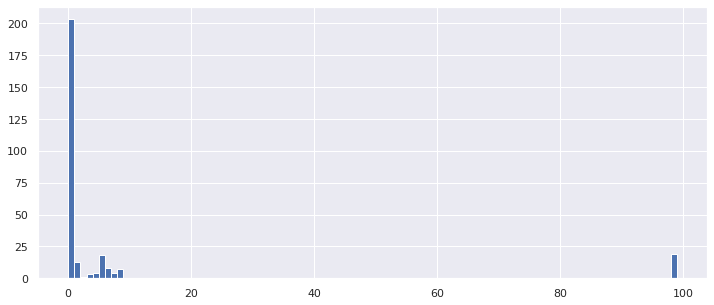

In [461]:
plt.figure(figsize=(12,5))
#plt.scatter(replay_combined_matching['realtime_rip'].values,replay_combined_matching['off_max_arm'].values,s=5)
#plt.scatter(replay_combined_matching['realtime_rip'].values,replay_combined_matching['rt_max_arm'].values,s=5)
plt.hist(replay_combined_matching['off_max_arm'].values,bins=99)
replay_combined_matching.shape

(280, 17)

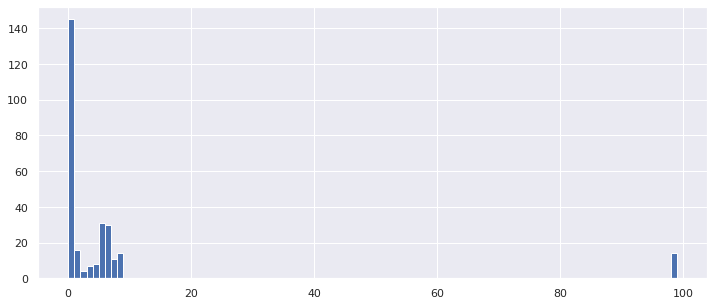

In [462]:
plt.figure(figsize=(12,5))
#plt.scatter(replay_combined_matching['realtime_rip'].values,replay_combined_matching['off_max_arm'].values,s=5)
#plt.scatter(replay_combined_matching['realtime_rip'].values,replay_combined_matching['rt_max_arm'].values,s=5)
plt.hist(replay_combined_matching['rt_max_arm'].values,bins=99)
replay_combined_matching.shape

In [384]:
blank_array = np.zeros((2,12))
blank_array[1,5] = 5
blank_array
posterior_sum[0]
offline_posterior_sum_all
off_post_sum_summary = pd.DataFrame(data=offline_posterior_sum_all,columns=('offline_rip','realtime_rip',
                                                                            'off_max_arm','box','arm1','arm2',
                                                                            'arm3','arm4','arm5','arm6',
                                                                            'arm7','arm8'))

In [125]:
# makes a movie for each time bin of the realtime decoder: liklihood and posterior
from ipywidgets import interact
@interact(i=(0, 1000))
def _plot(i=0):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    axes[0].plot(posterior_only_merged.iloc[i])
    axes[1].plot(likelihood_only.iloc[i])

interactive(children=(IntSlider(value=0, description='i', max=1000), Output()), _dom_classes=('widget-interact…

(1174, 137)


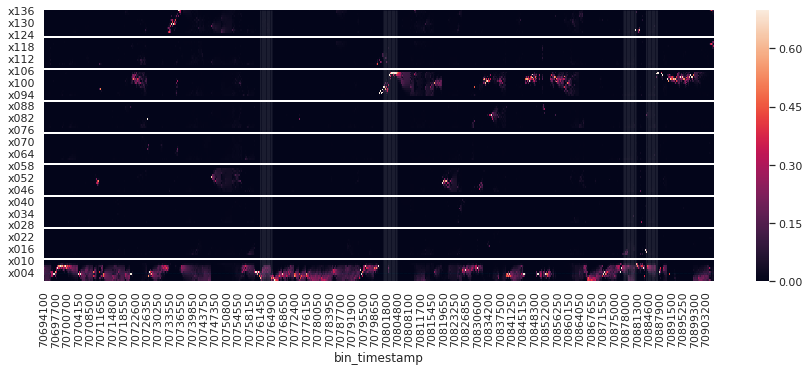

In [153]:
    # plot single realtime ripple
    #posterior from decode/stim message merged table
    merged_to_plot = merged_decoder_lockout[(merged_decoder_lockout['bin_timestamp'] > 70700060-30*200) & 
                                            (merged_decoder_lockout['bin_timestamp'] < 70900060+30*200)]
    merged_to_plot.set_index('bin_timestamp',inplace=True)
    posterior_only_merged = merged_to_plot.drop(['rec_ind','wall_time','velocity','real_pos',
                                                'spike_count','ripple','ripple_length',
                                                'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                                                'arm6','arm7','arm8','posterior_max_arm','shortcut_message_sent',
                                                'raw_x','raw_y','smooth_x','smooth_y','ripple_number_x',
                                                'ripple_number_y','ripple_end','lockout_state','lockout_num'], axis=1)
    # ripple time - generated from lockout_state
    ripples_to_plot = merged_to_plot.reset_index()
    ripple_times = ripples_to_plot.index[ripples_to_plot['lockout_state'] > 0].tolist()

    #posterior_only
    print(posterior_only_merged.shape)
    
    #plot heatmap with posterior surrounding each ripple
    post_heatmap = posterior_only_merged.transpose()
    post_heatmap = post_heatmap.iloc[::-1]
    
    plt.figure(figsize=(15,5))
    #plt.title(f'Real-time posterior, ripple {ripple_num}. Max arm {max_arm}')
    ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
    #gap lines need to be inverse of where you would expect
    ax.hlines([135-9,135-25,135-41,135-57,135-73,135-89,135-105,135-121], lw=2, color='w',*ax.get_xlim())
    ax.scatter(np.arange(0,merged_to_plot.shape[0]),136-merged_to_plot['real_pos'].values,s=1,alpha=0.01,color='cyan')
    #ax.scatter(stim_lockout['timestamp'].values,(stim_lockout['lockout_state'].values)*50,s=2,alpha=1)
    ax.vlines(ripple_times,lw=1,color='w',alpha=0.05,*ax.get_ylim())

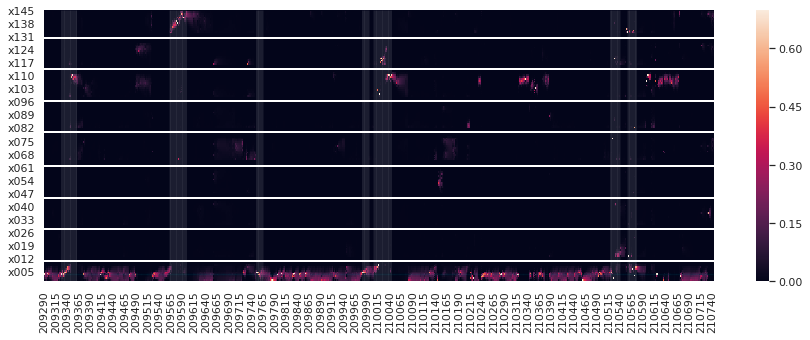

In [154]:
    # plot single offline ripple
    posterior_to_plot = merged_off_post_pos[(merged_off_post_pos['timestamp'] > 70700060+1958987-30*300) & 
                                            (merged_off_post_pos['timestamp'] < 70900060+1958987+30*300)]

    ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] > 0].tolist()

    posterior_offline1 = posterior_to_plot.drop(['day_x','epoch_x','timestamp','time_x','num_spikes','dec_bin',
                                                 'ripple_grp','day_y','epoch_y','time_y','linpos_flat',
                                                 'linvel_flat'], axis=1)

    posterior_offline2 = posterior_offline1.fillna(0)
    post_heatmap = posterior_offline2.transpose()
    post_heatmap = post_heatmap.iloc[::-1]
    
    #realtime_ripple_num = matching_offline_rips['lockout_num'][index:index+1].values
    #ripple_num_index = int(len(posterior_to_plot)*0.6)
    #ripple_num = posterior_to_plot[ripple_num_index:ripple_num_index+1]['ripple_grp'].values 

    plt.figure(figsize=(15,5))
    #plt.title(f'Offline posterior, offline rip {ripple_num}. Realtime rip {realtime_ripple_num}')
    ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
    ax.hlines([145-10,145-27,145-44,145-61,145-79,145-96,145-113,145-130], lw=2, color='w',*ax.get_xlim())
    ax.scatter(np.arange(0,posterior_to_plot.shape[0]),145-posterior_to_plot['linpos_flat'].values,s=2,alpha=0.01,color='cyan')
    ax.vlines([ripple_times-posterior_to_plot.index[0]],lw=1,color='w',alpha=0.05,*ax.get_ylim())

In [ ]:
plt.figure(figsize=(12,5))
plt.scatter(offline_pos['timestamp'][0:3000].values,offline_pos['linpos_flat'][0:3000].values, s=4)
plt.scatter(merged_offline_posterior_pos['timestamp'][0:20000].values,merged_offline_posterior_pos['linpos_flat'][0:20000].values, s=2, alpha=0.05)


In [135]:
# ripple from real-time timestamps: 87475500 - 87585000
stim_lockout[(stim_lockout['timestamp']>87475500) & (stim_lockout['timestamp']<87585000)]

,rec_ind,timestamp,time,lockout_num,lockout_state,tets_above_thresh,big_rip_message_sent
398,119886,87478860,4.668738e+00,199,1,2,1
399,119897,87482620,1.580166e+09,199,0,0,1


In [102]:
realtime_rips
decoder_data
trials_timestamp = trials.copy()
trials_timestamp

starttime      endtime
day epoch trial                          
20  2     0      1375.220333  1524.100333
          1      1524.100333  1581.400333
          2      1581.400333  1618.258333
          3      1618.258333  1646.974333
          4      1646.974333  1697.465333
...                      ...          ...
          104    5314.083333  5335.145333
          105    5335.145333  5366.125333
          106    5366.125333  5410.345333
          107    5410.345333  5449.408333
          108    5449.408333  5483.735333

[109 rows x 2 columns]

In [118]:
trials_timestamp['start_ts'] = trials_timestamp['starttime']*30000
trials_timestamp['end_ts'] = trials_timestamp['endtime']*30000
trials_timestamp
rips

<RippleTimes: 79c5aeab-0a63-4e84-9deb-80f490b22e1e, shape: ((1256, 4))>

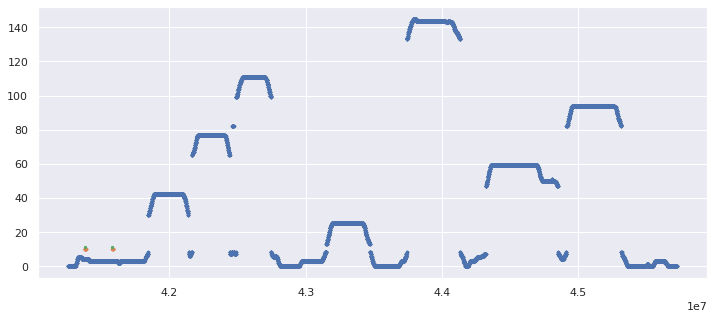

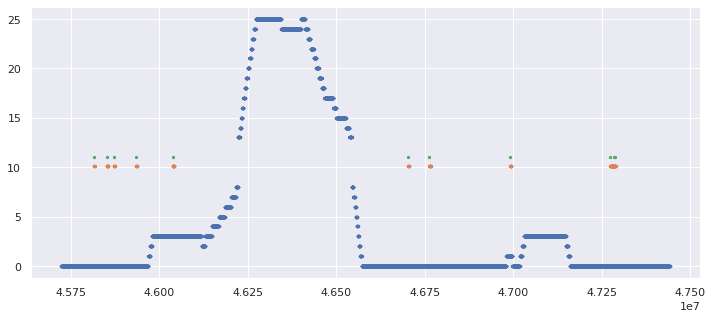

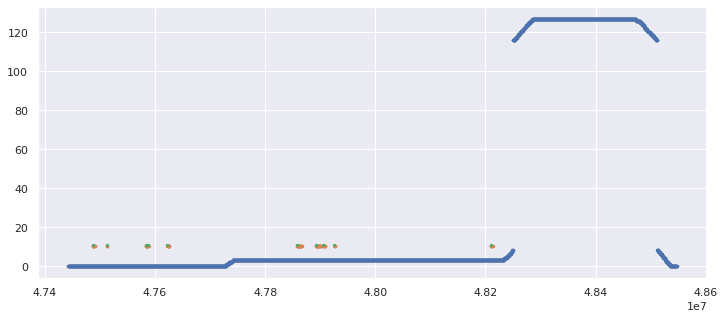

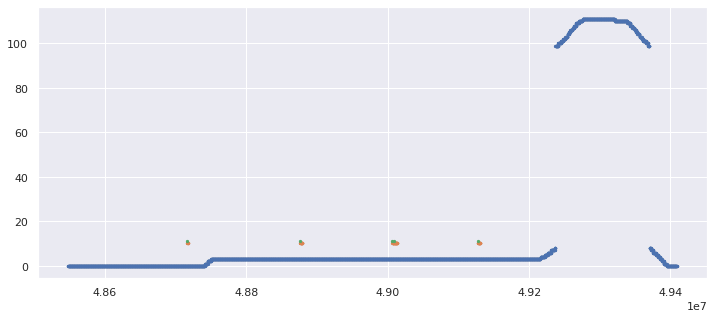

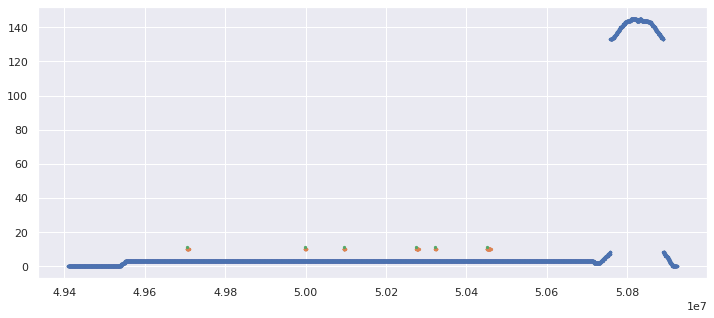

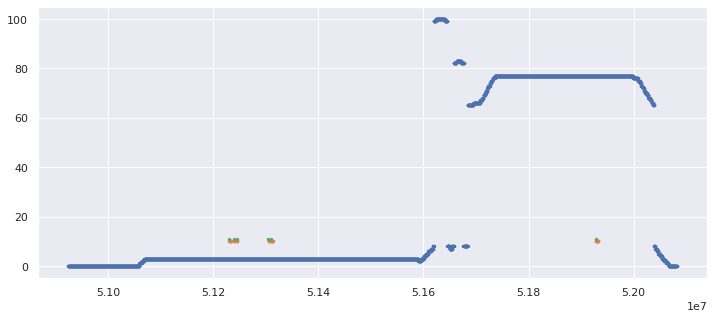

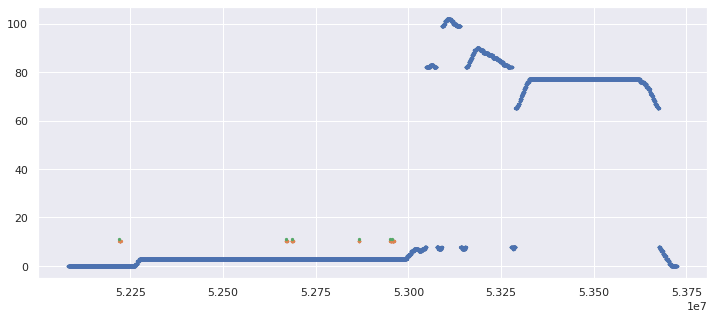

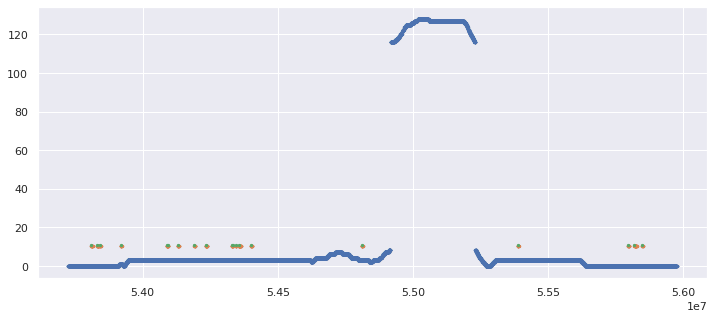

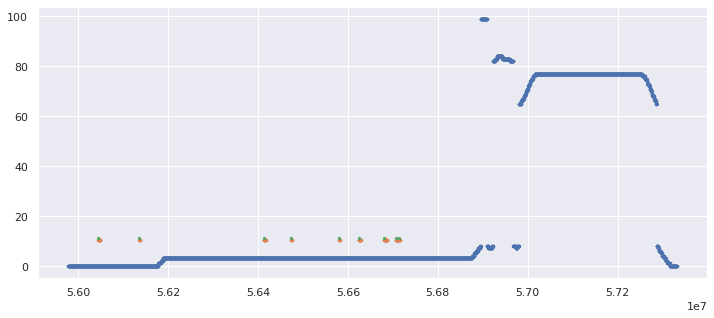

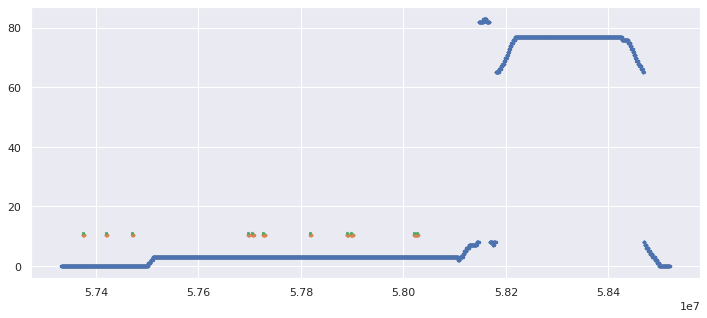

In [123]:
#plotting to check ripple detection offline and realtime

for i in np.arange(0,10):
    trial_start = trials_timestamp['start_ts'][i:i+1].values[0]
    trial_end = trials_timestamp['end_ts'][i:i+1].values[0]
    trial_post = merged_off_post_pos[(merged_off_post_pos['timestamp'].values > trial_start) & (merged_off_post_pos['timestamp'].values < trial_end)]
    trial_post_rips = trial_post[trial_post['ripple_grp']>0]
    all_rips = rips.reset_index()
    all_rips_plot = all_rips[(all_rips['timestamp'].values > trial_start) & (all_rips['timestamp'].values < trial_end)]
    plt.figure(figsize=(12,5))
    plt.scatter(trial_post['timestamp'].values,trial_post['linpos_flat'].values,s=5)
    plt.scatter(trial_post_rips['timestamp'].values,(trial_post_rips['ripple_grp'].values/1000)+10,s=5)
    plt.scatter(all_rips_plot['timestamp'].values,np.repeat(11,len(all_rips_plot)),s=5)


In [122]:
np.repeat(11,len(all_rips_plot))

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])

In [62]:
#calculate max for offline posteriors
post_to_merge = posteriors2.copy()

#calculate posterior max
post_to_merge1 = post_to_merge.drop(['num_spikes','dec_bin','ripple_grp'], axis=1)
post_to_merge1.fillna(0,inplace=True)
post_to_merge1['posterior_max'] = post_to_merge1.idxmax(axis=1)
post_to_merge1['posterior_max'] = post_to_merge1['posterior_max'].str.replace('x','')
post_to_merge1['posterior_max'] = post_to_merge1['posterior_max'].astype(int)

#post_to_merge.reset_index(level=['timestamp'],inplace=True)
post_to_merge1.reset_index(inplace=True)
post_to_merge1['timestamp1']=post_to_merge1['timestamp']

#calculate posterior max

#post_to_merge.set_index('timestamp', append=True, inplace=True)
#post_to_merge.set_index('dat','epoch','timestamp', 'time',append=True, inplace=True)
#post_to_merge1 = post_to_merge.reorder_levels(['day', 'epoch', 'timestamp', 'time'])
post_to_merge1

pos_vel = binned_linear_pos.copy()
pos_vel1 = pos_vel.reset_index()
pos_vel1['timestamp1'] = pos_vel1['timestamp']
pos_vel2 = pos_vel1.drop(['day','epoch','time','timestamp'], axis=1)

posterior_with_pos_vel = pd.merge_asof(post_to_merge1,pos_vel2,on='timestamp1',direction='nearest')
posterior_with_pos_vel['error_cm'] = abs(posterior_with_pos_vel['posterior_max']-posterior_with_pos_vel['linpos_flat'])*5
posterior_with_pos_vel

post_error_plot_off = posterior_with_pos_vel.copy()
#post_error_plot_off = post_error_plot[100:821700]
post_error_plot_off = post_error_plot_off[post_error_plot_off['linvel_flat']>4]
post_error_plot_off.shape

(194133, 155)

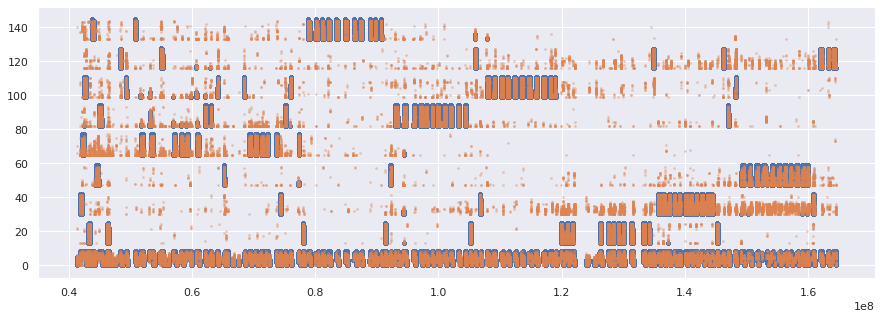

In [63]:
#offline position and decoded position
plt.figure(figsize=(15,5))

plt.scatter(post_error_plot_off['timestamp'].values,post_error_plot_off['linpos_flat'].values,s=10)
plt.scatter(post_error_plot_off['timestamp'].values,post_error_plot_off['posterior_max'].values,s=3,alpha=0.3)


In [ ]:
list(decoder_data3)

In [64]:
# for real-time posterior
post_error1 = decoder_data.copy()
#post_error1 = likelihood_data.copy()

post_error1.drop(columns=['rec_ind','wall_time','bin_timestamp','velocity','real_pos','spike_count','ripple',
                          'ripple_number','ripple_length','shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                          'arm6','arm7','arm8','raw_x','raw_y','smooth_x','smooth_y'],inplace=True)

#post_error1.drop(columns=['rec_ind','timestamp','real_pos_time','real_pos','spike_count','ripple',
#                          'box','arm1','arm2','arm3','arm4','arm5',
#                          'arm6','arm7','arm8'],inplace=True)

#post_error1.drop(columns=['rec_ind','wall_time','bin_timestamp','real_pos','spike_count'],inplace=True)

post_error1.fillna(0,inplace=True)
post_error1['max_position'] = post_error1.idxmax(axis=1)
post_error1['max_position'] = post_error1['max_position'].str.replace('x','')
post_error1['max_position'] = post_error1['max_position'].astype(int)

#now need to add back columns 'timestamp','real_pos_time','real_pos'
# try adding back spike_count too
post_error1['timestamp'] = decoder_data['bin_timestamp']
post_error1['real_vel'] = decoder_data['velocity']
post_error1['real_pos'] = decoder_data['real_pos']
post_error1['spike_count'] = decoder_data['spike_count']
#this is the error column in centimeters
post_error1['error_cm'] = abs(post_error1['max_position']-decoder_data['real_pos'])*5

post_error1.shape
post_error_plot_realtime = post_error1[post_error1['real_vel']>8]
post_error_plot_realtime.shape

(164469, 143)

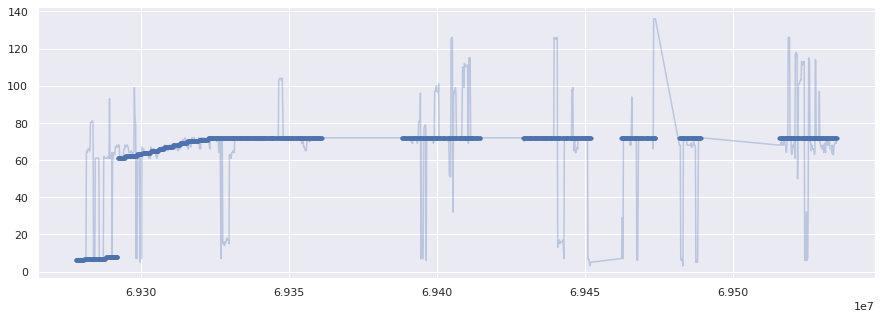

In [119]:
# remy day 20 epoch 2 realtime - westerlies
# 150 uV, 19 tets, no timer
# new trodes (12-19)
plt.figure(figsize=(15,5))
time_slice = slice(94000, 95000)
plt.scatter(post_error_plot_realtime['timestamp'][time_slice].values,
            post_error_plot_realtime['real_pos'][time_slice].values,s=10)
plt.plot(post_error_plot_realtime['timestamp'][time_slice].values,
         post_error_plot_realtime['max_position'][time_slice].values,alpha=0.3)


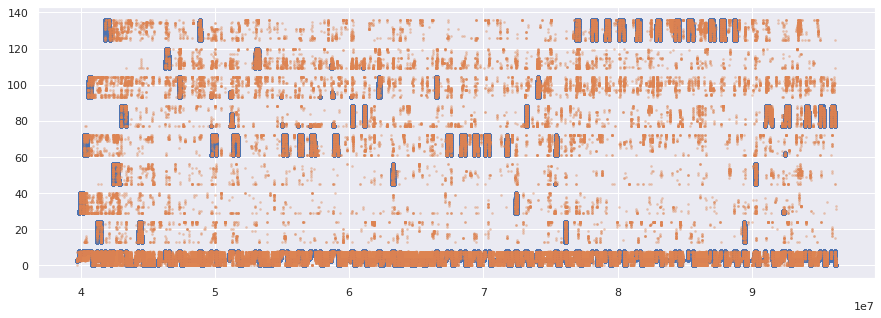

In [281]:
# remy day 20 epoch 2 realtime - westerlies
# 150 uV, 19 tets, no timer
# OLD TRODES
plt.figure(figsize=(15,5))

plt.scatter(post_error_plot_realtime['timestamp'].values,post_error_plot_realtime['real_pos'].values,s=10)
plt.scatter(post_error_plot_realtime['timestamp'].values,post_error_plot_realtime['max_position'].values,s=3,alpha=0.3)


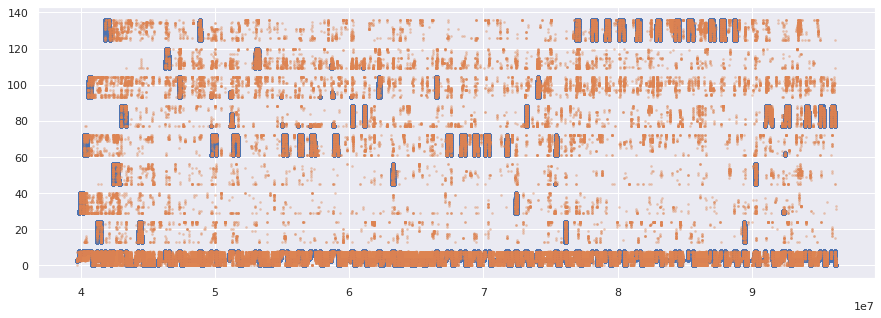

In [65]:
# remy day 20 epoch 2 realtime - westerlies
# 150 uV, 19 tets, no timer
# OLD TRODES
plt.figure(figsize=(15,5))

plt.scatter(post_error_plot_realtime['timestamp'].values,post_error_plot_realtime['real_pos'].values,s=10)
plt.scatter(post_error_plot_realtime['timestamp'].values,post_error_plot_realtime['max_position'].values,s=3,alpha=0.3)


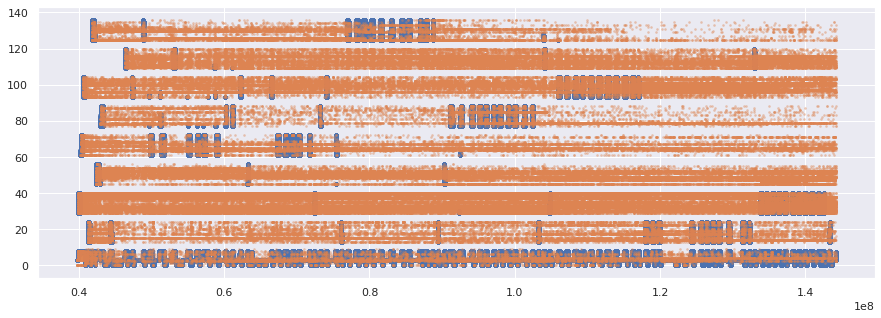

In [143]:
# remy day 20 epoch 2 realtime - likelihoods
# 150 uV, 15 tets, no timer
plt.figure(figsize=(15,5))

plt.scatter(post_error1['timestamp'].values,post_error1['real_pos'].values,s=10)
plt.scatter(post_error1['timestamp'].values,post_error1['max_position'].values,s=3,alpha=0.3)


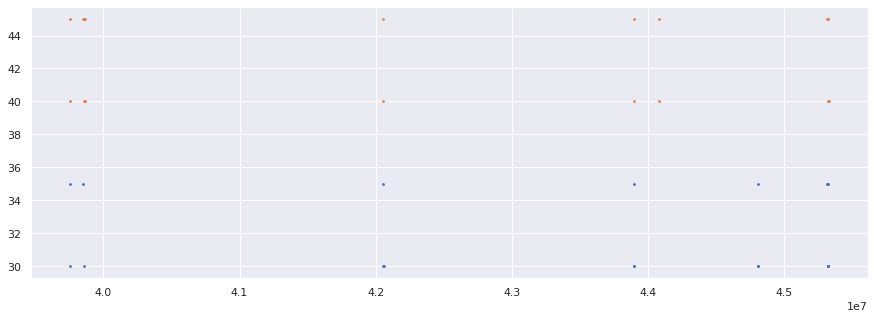

In [288]:
# ripples in old trodes 30 min decode westerlies vs previous one
# note: different velocity threshold
# stim_lockout: 10 cm/sec (15 tets on greenflash)
# stim_lockout19: 8 cm/sec (19 tets on westerlies)
# need to apply velocity threshold to offline ripples too - yes it is already applied

plt.figure(figsize=(15,5))

plt.scatter(stim_lockout['timestamp'][0:20].values,stim_lockout['lockout_state'][0:20].values*5+30,s=3)
plt.scatter(stim_lockout19['timestamp'][0:20].values,stim_lockout19['lockout_state'][0:20].values*5+40,s=3)

<IPython.core.display.Javascript object>


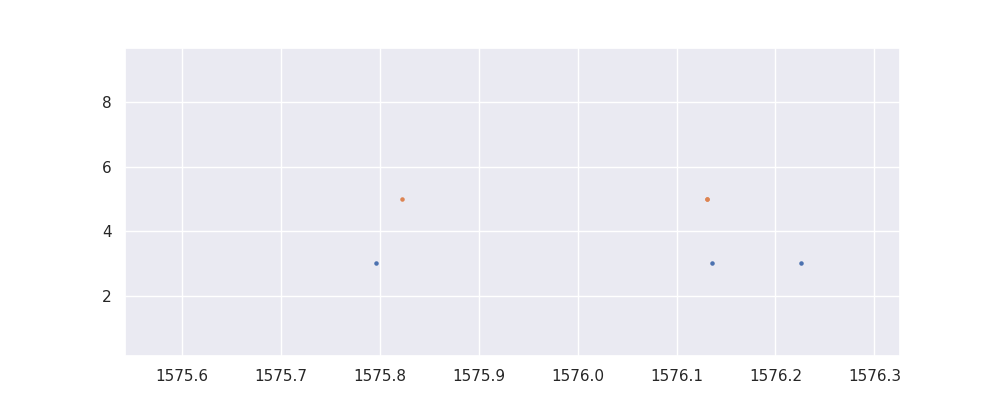

(0, 10)

In [194]:
%matplotlib notebook
# see how far before realtime rip detection to set posterior sum
# plot realtime and offline rip starts
plt.figure(figsize=(10,4))
plt.scatter(matching_offline_rips['timestamp_x'].values/30000,np.repeat(3, 202),s=5)
plt.scatter((matching_offline_rips['timestamp_y'].values+1958987-2100)/30000,np.repeat(5, 202),s=5)
plt.ylim([0,10])
#matching_offline_rips.shape

<IPython.core.display.Javascript object>


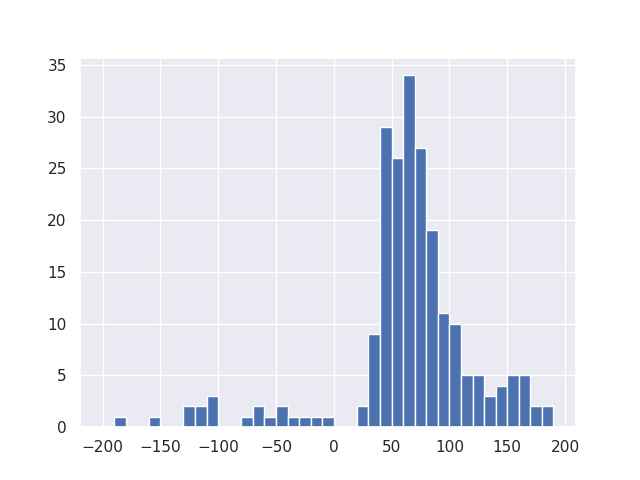

(array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  2.,  2.,  3.,  0.,  0.,  1.,
         2.,  1.,  2.,  1.,  1.,  1.,  1.,  0.,  0.,  2.,  9., 29., 26.,
        34., 27., 19., 11., 10.,  5.,  5.,  3.,  4.,  5.,  5.,  2.,  2.]),
 array([-200, -190, -180, -170, -160, -150, -140, -130, -120, -110, -100,
         -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,   10,
          20,   30,   40,   50,   60,   70,   80,   90,  100,  110,  120,
         130,  140,  150,  160,  170,  180,  190]),
 <a list of 39 Patch objects>)

In [171]:
#histogram of delay in realtime ripple compared to offline
# result: most common time delay is 60-70 msec, with the 150-250 Hz filter and SD = 5 with Anna's baseline values
# this delay will probably need to be calculated for each new animal / day
# for the analysis no, let use 70 msec as the shift and see how that works
# so for posterior sum, we want 70 msec before stim lockout and 50 msec after
plt.hist(((matching_offline_rips['timestamp_y'].values+1958987)-
          matching_offline_rips['timestamp_x'].values)/30,bins=np.arange(-200,200,10))


In [159]:
matching_offline_rips

,day,epoch,event,timestamp_x,starttime,endtime,maxthresh,adj_timestamp,rec_ind,timestamp_y,time,lockout_num,lockout_state,tets_above_thresh,big_rip_message_sent
19,20,2,66,45852404,1528.413467,1528.517467,6.582024,45852404,10541.0,43895760.0,0.745635,5.0,1.0,2.0,1.0
22,20,2,69,46038044,1534.601467,1534.742133,3.670240,46038044,11010.0,44082520.0,6.087636,6.0,1.0,2.0,1.0
26,20,2,86,47273884,1575.796133,1576.112800,10.921949,47273884,14100.0,45317800.0,5.746183,7.0,1.0,2.0,1.0
27,20,2,87,47284084,1576.136133,1576.206133,4.838653,47284084,14127.0,45327040.0,7.470352,9.0,1.0,2.0,1.0
28,20,2,88,47286764,1576.225467,1576.290800,2.473105,47286764,14127.0,45327040.0,7.470352,9.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,20,2,972,96823943,3227.464800,3227.620800,4.975869,96823943,138451.0,94868840.0,5.986134,244.0,1.0,2.0,1.0
509,20,2,973,96828744,3227.624800,3227.921467,12.799470,96828744,138451.0,94868840.0,5.986134,244.0,1.0,2.0,1.0
513,20,2,991,97665543,3255.518133,3255.810800,15.995828,97665543,140564.0,95711360.0,3.849507,247.0,1.0,2.0,1.0
514,20,2,995,97987884,3266.262800,3266.331467,3.618805,97987884,141364.0,96029740.0,3.790184,249.0,1.0,2.0,1.0


In [ ]:
# below are scratch cells for posterior plotting

In [195]:
stim_message3[stim_message3['shortcut_message_sent']>0]
stim_message3[0:10]
shortcut_message_to_plot = stim_message3[(stim_message3['bin_timestamp'] > timestamp-30*300) & 
                                         (stim_message3['bin_timestamp'] < timestamp+30*300)]
print(timestamp)
shortcut_message_to_plot
merged_to_plot_index = merged_to_plot.reset_index()
# want to return index in merged_to_plot for bin_timestamp in shortcut_message_to_plot
merged_to_plot_index.index[merged_to_plot_index['bin_timestamp'].values == shortcut_message_to_plot['bin_timestamp'].values].tolist()


75870540


[33]

In [227]:
index_test[0]
merged_to_plot_index.index[merged_to_plot_index['bin_timestamp'].values == shortcut_message_to_plot['bin_timestamp'][i:i+1].values].tolist()[0]
shortcut_message_to_plot['shortcut_message_sent'].values


array([0, 1])

In [226]:
shortcut_message_to_plot
#shortcut_message_to_plot['shortcut_message_sent'].values*100
#stim_message3[10:20]
index_test = np.zeros(shortcut_message_to_plot.shape[0])
for i in np.arange(0,shortcut_message_to_plot.shape[0]):
    print(shortcut_message_to_plot['bin_timestamp'][i:i+1].values)
    index_test[i] = merged_to_plot_index.index[merged_to_plot_index['bin_timestamp'].values == shortcut_message_to_plot['bin_timestamp'][i:i+1].values].tolist()[0]
index_test
#shortcut_message_to_plot.shape[0]

[77259000]
[77262450]


array([34., 49.])

In [194]:
merged_to_plot['shortcut_message_sent'].values
#for timestamp in stim_lockout3[stim_lockout3['lockout_state']==1]['timestamp'][10:15].values:
#    print(timestamp)
merged_to_plot.reset_index()[30:40]

,bin_timestamp,rec_ind,wall_time,velocity,real_pos,raw_x,raw_y,smooth_x,smooth_y,spike_count,...,x135,x136,shortcut_message_sent,ripple_number_y,delay,posterior_max_arm,ripple_end,lockout_num,lockout_state,timestamp_shift
30,75868950,22436,1.580754e+09,5.545489,3.0,667.0,389.0,666.5177,389.7246,0,...,8.545270e-04,8.545270e-04,1,14,30.333333,6,1,14.0,1.0,75868440.0
31,75869400,22438,1.580754e+09,5.545489,3.0,667.0,389.0,666.5177,389.7246,2,...,7.457659e-13,7.457659e-13,1,14,30.333333,6,1,14.0,1.0,75868440.0
32,75869850,22441,1.580754e+09,5.299752,3.0,667.0,389.0,666.5259,389.6897,3,...,4.178165e-09,4.178165e-09,1,14,30.333333,6,1,14.0,1.0,75868440.0
33,75870150,22444,1.580754e+09,5.299752,3.0,667.0,389.0,666.5259,389.6897,2,...,8.193522e-14,8.193522e-14,1,14,30.333333,6,1,14.0,1.0,75868440.0
34,75870300,22446,1.580754e+09,5.299752,3.0,667.0,389.0,666.5259,389.6897,0,...,9.896112e-05,9.896112e-05,1,14,30.333333,6,1,14.0,1.0,75868440.0
35,75870450,22448,1.580754e+09,5.299752,3.0,667.0,389.0,666.5259,389.6897,0,...,1.968941e-04,1.968941e-04,1,14,30.333333,6,1,14.0,1.0,75868440.0
36,75870900,22450,1.580754e+09,5.097650,3.0,666.0,389.0,666.4954,389.6552,2,...,1.025571e-10,1.025571e-10,1,14,30.333333,6,1,14.0,1.0,75868440.0
37,75871200,22452,1.580754e+09,5.097650,3.0,666.0,389.0,666.4954,389.6552,1,...,1.575434e-08,1.575434e-08,1,14,30.333333,6,1,14.0,1.0,75868440.0
38,75871500,22454,1.580754e+09,4.995355,3.0,666.0,390.0,666.4652,389.6603,2,...,3.650851e-08,3.650851e-08,1,14,30.333333,6,1,14.0,1.0,75868440.0
39,75871950,22456,1.580754e+09,4.963294,3.0,666.0,390.0,666.4355,389.6657,2,...,3.213001e-08,3.213001e-08,1,14,30.333333,6,1,14.0,1.0,75868440.0


# plotting position and velocity

(300, 350)

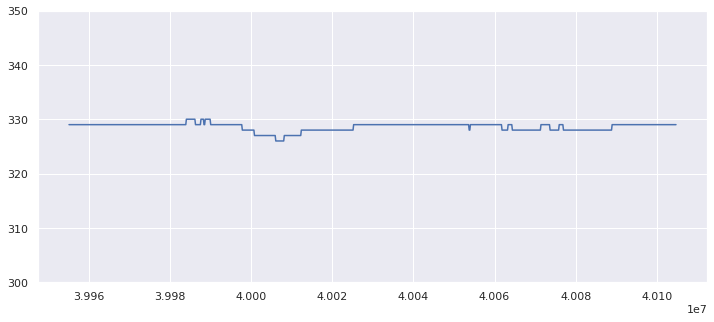

In [621]:
decoder_data14
decoder_pos_plot = decoder_data14[(decoder_data14['bin_timestamp']>39955000) & 
                                  (decoder_data14['bin_timestamp']<40104850)]
plt.figure(figsize=(12,5))
plt.scatter(decoder_pos_plot['bin_timestamp'].values,decoder_pos_plot['real_pos'].values,s=3)
plt.scatter(decoder_pos_plot['bin_timestamp'].values,decoder_pos_plot['velocity'].values,s=3)
plt.plot(decoder_pos_plot['bin_timestamp'].values,decoder_pos_plot['raw_x'].values)
plt.plot(decoder_pos_plot['bin_timestamp'].values,decoder_pos_plot['raw_y'].values)
plt.ylim(300,350)

In [594]:
decoder_pos_plot[100:110]

,rec_ind,bin_timestamp,wall_time,velocity,real_pos,raw_x,raw_y,smooth_x,smooth_y,spike_count,...,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136
1101,2631,39870150,1.580922e+09,112.733587,4.0,686.0,330.0,692.4572,370.2373,1,...,8.020099e-20,8.020099e-20,8.020099e-20,8.020099e-20,8.020099e-20,8.020099e-20,8.020099e-20,8.020099e-20,8.020099e-20,8.020099e-20
1102,2634,39870300,1.580922e+09,130.662842,4.0,682.0,325.0,691.9984,368.0370,1,...,9.896473e-05,9.896473e-05,9.896473e-05,9.896473e-05,9.896473e-05,9.896473e-05,9.896473e-05,9.896473e-05,9.896473e-05,9.896473e-05
1103,2636,39870450,1.580922e+09,130.662842,4.0,682.0,325.0,691.9984,368.0370,5,...,1.969027e-04,1.969027e-04,1.969027e-04,1.969027e-04,1.969027e-04,1.969027e-04,1.969027e-04,1.969027e-04,1.969027e-04,1.969027e-04
1104,2638,39870600,1.580922e+09,130.662842,4.0,682.0,325.0,691.9984,368.0370,1,...,1.576445e-27,1.576445e-27,1.576445e-27,1.576445e-27,1.576445e-27,1.576445e-27,1.576445e-27,1.576445e-27,1.576445e-27,1.576445e-27
1105,2640,39870750,1.580922e+09,130.662842,4.0,682.0,325.0,691.9984,368.0370,1,...,9.896515e-05,9.896515e-05,9.896515e-05,9.896515e-05,9.896515e-05,9.896515e-05,9.896515e-05,9.896515e-05,9.896515e-05,9.896515e-05
1106,2644,39870900,1.580922e+09,130.662842,4.0,682.0,325.0,691.9984,368.0370,5,...,1.969044e-04,1.969044e-04,1.969044e-04,1.969044e-04,1.969044e-04,1.969044e-04,1.969044e-04,1.969044e-04,1.969044e-04,1.969044e-04
1107,2646,39871050,1.580922e+09,130.662842,4.0,682.0,325.0,691.9984,368.0370,2,...,1.452878e-30,1.452878e-30,1.452878e-30,1.452878e-30,1.452878e-30,1.452878e-30,1.452878e-30,1.452878e-30,1.452878e-30,1.452878e-30
1108,2648,39871200,1.580922e+09,130.662842,4.0,682.0,325.0,691.9984,368.0370,4,...,1.050415e-09,1.050415e-09,1.050415e-09,1.050415e-09,1.050415e-09,1.050415e-09,1.050415e-09,1.050415e-09,1.050415e-09,1.050415e-09
1109,2652,39871350,1.580922e+09,130.662842,4.0,682.0,325.0,691.9984,368.0370,5,...,2.175654e-21,2.175654e-21,2.175654e-21,2.175654e-21,2.175654e-21,2.175654e-21,2.175654e-21,2.175654e-21,2.175654e-21,2.175654e-21
1110,2654,39871500,1.580922e+09,130.662842,4.0,682.0,325.0,691.9984,368.0370,4,...,3.230415e-16,3.230415e-16,3.230415e-16,3.230415e-16,3.230415e-16,3.230415e-16,3.230415e-16,3.230415e-16,3.230415e-16,3.230415e-16


(-1, 100)

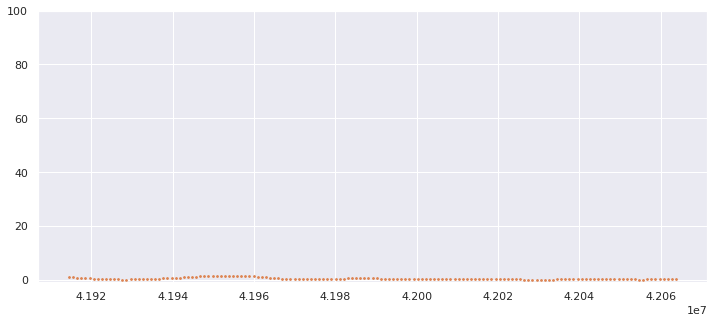

In [611]:
#offline linear_pos_raw or binned_linear_pos
linear_pos_raw_reset = linear_pos_raw.reset_index()
offline_pos_plot = linear_pos_raw_reset[(linear_pos_raw_reset['timestamp']>39955000+1958987) & 
                                  (linear_pos_raw_reset['timestamp']<40104850+1958987)]
plt.figure(figsize=(12,5))
plt.scatter(offline_pos_plot['timestamp'].values,offline_pos_plot['linpos_flat'].values,s=3)
plt.scatter(offline_pos_plot['timestamp'].values,offline_pos_plot['linvel_flat'].values,s=3)
plt.ylim(-1,100)

(125, 175)

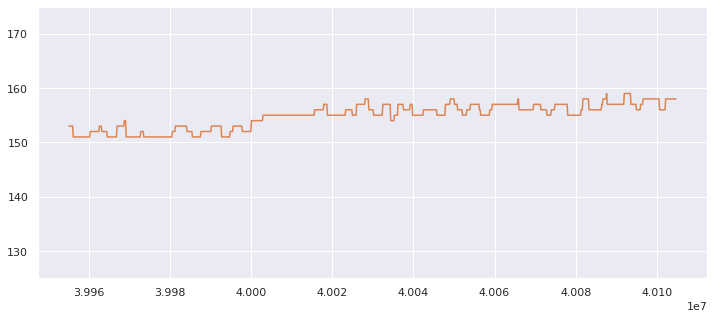

In [613]:
decoder_data15
decoder_pos_plot = decoder_data15[(decoder_data15['bin_timestamp']>39955000) & 
                                  (decoder_data15['bin_timestamp']<40104850)]
plt.figure(figsize=(12,5))
plt.scatter(decoder_pos_plot['bin_timestamp'].values,decoder_pos_plot['real_pos'].values,s=3)
plt.scatter(decoder_pos_plot['bin_timestamp'].values,decoder_pos_plot['velocity'].values,s=3)
plt.plot(decoder_pos_plot['bin_timestamp'].values,decoder_pos_plot['raw_x'].values)
plt.plot(decoder_pos_plot['bin_timestamp'].values,decoder_pos_plot['raw_y'].values)
plt.ylim(125,175)

In [606]:
decoder_data15

,rec_ind,bin_timestamp,wall_time,velocity,real_pos,raw_x,raw_y,smooth_x,smooth_y,spike_count,...,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136
0,1,39682500,1.581037e+09,186.680718,2.0,695.0,366.0,0.0,0.0,4,...,9.584651e-03,9.584651e-03,9.584651e-03,9.584651e-03,9.584651e-03,9.584651e-03,9.584651e-03,9.584651e-03,9.584651e-03,9.584651e-03
1,3,39682650,1.581037e+09,186.680718,2.0,695.0,366.0,0.0,0.0,0,...,9.583988e-03,9.583988e-03,9.583988e-03,9.583988e-03,9.583988e-03,9.583988e-03,9.583988e-03,9.583988e-03,9.583988e-03,9.583988e-03
2,10,39682800,1.581037e+09,186.680718,2.0,695.0,366.0,0.0,0.0,10,...,8.013079e-05,8.013079e-05,8.013079e-05,8.013079e-05,8.013079e-05,8.013079e-05,8.013079e-05,8.013079e-05,8.013079e-05,8.013079e-05
3,14,39682950,1.581037e+09,186.427237,2.0,692.0,366.0,0.0,0.0,5,...,2.590359e-04,2.590359e-04,2.590359e-04,2.590359e-04,2.590359e-04,2.590359e-04,2.590359e-04,2.590359e-04,2.590359e-04,2.590359e-04
4,16,39683100,1.581037e+09,186.427237,2.0,692.0,366.0,0.0,0.0,1,...,7.522399e-13,7.522399e-13,7.522399e-13,7.522399e-13,7.522399e-13,7.522399e-13,7.522399e-13,7.522399e-13,7.522399e-13,7.522399e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12884,31178,41615100,1.581037e+09,5.491447,0.0,776.0,436.0,0.0,0.0,1,...,7.013360e-04,4.324725e-04,3.897104e-04,3.897104e-04,3.897104e-04,3.897104e-04,3.897104e-04,3.897104e-04,3.897104e-04,3.897104e-04
12885,31182,41615250,1.581037e+09,5.491447,0.0,776.0,436.0,0.0,0.0,4,...,9.893778e-04,6.015200e-04,4.987248e-04,4.846189e-04,4.846189e-04,4.846189e-04,4.846189e-04,4.846189e-04,4.846189e-04,4.846189e-04
12886,31184,41615400,1.581037e+09,5.250826,0.0,776.0,436.0,0.0,0.0,3,...,1.584365e-39,9.697037e-40,7.648736e-40,7.174354e-40,7.117113e-40,7.117113e-40,7.117113e-40,7.117113e-40,7.117113e-40,7.117113e-40
12887,31186,41615550,1.581037e+09,5.250826,0.0,776.0,436.0,0.0,0.0,3,...,1.934317e-19,1.934317e-19,1.934317e-19,1.934317e-19,1.934317e-19,1.934317e-19,1.934317e-19,1.934317e-19,1.934317e-19,1.934317e-19
